In [320]:
import warnings
warnings.filterwarnings('ignore')

# EDA
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from matplotlib.colors import to_rgba
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pio.renderers.default = 'browser'
pio.kaleido.scope.default_format = "png"
pio.kaleido.scope.default_scale = 6
pio.kaleido.scope.default_width = 1080
pio.kaleido.scope.default_height = 1080

# scale=6, width=1080, height=1080

#Spotify API
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Clustring
from sklearn.decomposition import PCA

# Prediction
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, confusion_matrix, classification_report

# from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
# from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer,ModelSpecificationParser


pd.options.display.float_format = '{:.3f}'.format
# plotly.offline.init_notebook_mode(connected=True)

## Spotify API

Use `spotipy` to extract the playlist name as current data only has tokens.

In [321]:
spotify = spotipy.Spotify(auth_manager = SpotifyOAuth(client_id = 'de26dcabd1c64a3bab60050a6fbcc329',
                                                      client_secret = 'c7725ee40eda45c7bae5d102689d282a',
                                                      redirect_uri = 'http://localhost/',
                                                     ))

In [322]:
# Test if a playlist name can be extracted using spotipy
# spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())
print('the owner name of the test playlist is {}' \
      .format(spotify.playlist('spotify:user:36069af6af076ccd9e597184a67b68c9:playlist:5M8emOIVn1s6pfibDdCYEu')['owner']['display_name']))
print('the name of the test playlist is {}' \
      .format(spotify.playlist('spotify:user:36069af6af076ccd9e597184a67b68c9:playlist:5M8emOIVn1s6pfibDdCYEu')['name']))
print('the test playlist is a public? {}' \
      .format(spotify.playlist('spotify:user:36069af6af076ccd9e597184a67b68c9:playlist:5M8emOIVn1s6pfibDdCYEu')['public']))

the owner name of the test playlist is ronalddies
the name of the test playlist is Being Ambient Music Therapy with Binaural Beats – Ambient 12 - Clear - With Binaural Beats
the test playlist is a public? False


## Data Cleaning

In [323]:
file_path = '/Users/danielma/Documents/Spotify/presentation/'
df = pd.read_csv(file_path + 'playlist_revision_v02.txt', sep = "\t")
#\t means tab
df.head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,...,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
0,spotify:user:36069af6af076ccd9e597184a67b68c9:...,36069af6af076ccd9e597184a67b68c9,27,27,1,1,3,3,0,8,...,7,30,27,"[""ambient"", ""music"", ""therapy"", ""binaural"", ""b...",Dance & House,New Age,Country & Folk,Peaceful,Romantic,Somber
1,spotify:user:d1144a65b1c31c5f9f56b94f831124d5:...,d1144a65b1c31c5f9f56b94f831124d5,0,0,0,1,2,1,1,3,...,113,112,94,"[""good"", ""living""]",Pop,Indie Rock,Alternative,Excited,Yearning,Defiant
2,spotify:user:6b7fbed9edd6418ddd3b555bba441536:...,6b7fbed9edd6418ddd3b555bba441536,4,2,1,1,7,5,0,15,...,36,63,0,"[""norteña""]",Latin,-,-,Lively,Upbeat,Romantic
3,spotify:user:580b98725077a94c3c8d01d07390426b:...,580b98725077a94c3c8d01d07390426b,12,12,1,1,4,6,1,10,...,26,154,108,[],Dance & House,Electronica,Pop,Excited,Aggressive,Defiant
4,spotify:user:1305d39070c95d161cc502e15014897d:...,1305d39070c95d161cc502e15014897d,20,4,1,1,2,1,1,2,...,51,230,0,"[""cheesy"", ""pants""]",Indie Rock,Alternative,Electronica,Excited,Defiant,Yearning


In [324]:
df.dtypes

playlist_uri               object
owner                      object
streams                     int64
stream30s                   int64
dau                         int64
wau                         int64
mau                         int64
mau_previous_month          int64
mau_both_months             int64
users                       int64
skippers                    int64
owner_country              object
n_tracks                    int64
n_local_tracks              int64
n_artists                   int64
n_albums                    int64
monthly_stream30s           int64
monthly_owner_stream30s     int64
tokens                     object
genre_1                    object
genre_2                    object
genre_3                    object
mood_1                     object
mood_2                     object
mood_3                     object
dtype: object

In [325]:
df['playlist_uri'].nunique()

403366

In [326]:
print('the shape of the data is {}'.format(df.shape))
df[df['tokens']=='[]']['playlist_uri'].nunique()/df.shape[0]*100

the shape of the data is (403366, 25)


8.07405681192763

In [327]:
df[df['owner']!='spotify'].describe(include=[np.number], percentiles=[.25, .5, .75, .90, .95, .99])

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s
count,402967.000,402967.000,402967.000,402967.000,402967.000,402967.000,402967.000,402967.000,402967.000,402967.000,402967.000,402967.000,402967.000,402967.000,402967.000
mean,20.969,11.991,1.232,5.275,14.860,13.484,3.029,32.824,0.729,201.598,3.087,83.878,88.253,354.327,93.648
std,766.263,404.190,41.228,185.707,504.704,548.731,129.629,1157.602,27.054,584.349,40.350,128.207,133.249,10935.587,226.344
min,0.000,0.000,0.000,0.000,2.000,0.000,0.000,2.000,0.000,1.000,0.000,1.000,1.000,2.000,0.000
25%,0.000,0.000,0.000,1.000,2.000,1.000,1.000,2.000,0.000,38.000,0.000,18.000,19.000,31.000,6.000
50%,1.000,0.000,0.000,1.000,2.000,2.000,1.000,3.000,0.000,84.000,0.000,46.000,48.000,79.000,30.000
75%,8.000,5.000,1.000,2.000,4.000,3.000,2.000,7.000,0.000,192.000,0.000,101.000,106.000,193.000,96.000
90%,28.000,17.000,1.000,3.000,9.000,9.000,2.000,22.000,1.000,418.000,4.000,195.000,205.000,429.000,231.000
95%,51.000,31.000,2.000,7.000,21.000,19.000,3.000,50.000,1.000,683.000,10.000,287.000,301.000,723.000,376.000
99%,165.000,105.000,8.000,39.000,128.000,117.000,17.000,295.000,5.000,1872.000,52.000,588.000,614.000,2599.000,923.000


In [328]:
df[df['owner']=='spotify'].describe(include=[np.number], percentiles=[.25, .5, .75, .90, .95, .99])

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s
count,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000,399.000
mean,50613.368,31191.867,3221.937,16695.063,51858.419,45209.100,10019.180,117791.805,2122.807,85.321,0.065,57.145,59.371,916431.619,1.489
std,198887.911,115255.611,10881.344,48252.987,140532.850,111779.540,37988.590,267252.070,6112.706,88.041,0.691,40.903,43.046,3237110.802,3.702
min,0.000,0.000,0.000,0.000,2.000,0.000,0.000,2.000,0.000,10.000,0.000,1.000,1.000,2.000,0.000
25%,1361.500,885.500,131.500,843.000,3334.500,2248.000,212.000,9465.000,117.500,40.000,0.000,32.000,33.000,32376.500,0.000
50%,6794.000,4602.000,583.000,3731.000,13059.000,10741.000,1383.000,31699.000,462.000,59.000,0.000,47.000,49.000,154812.000,0.000
75%,29298.500,19410.000,2271.500,13267.500,43967.500,39007.500,5510.500,113226.500,1682.500,98.000,0.000,72.500,76.500,595835.000,1.000
90%,111259.600,69645.000,8183.600,43201.400,130304.600,114221.800,22671.800,299656.200,5738.400,173.000,0.000,101.200,103.000,2254059.000,4.000
95%,209636.600,124592.500,13732.600,73206.400,230516.700,209388.400,44549.600,518598.500,8102.600,227.100,0.000,125.100,129.600,3606808.900,6.100
99%,581300.320,346046.840,33153.540,121619.860,354017.300,395959.680,109785.400,918306.280,17158.480,420.080,1.020,208.720,229.400,8891014.080,15.040


In [329]:
# df_s = df[df['owner']!='spotify']

In [330]:
# plt.figure(figsize=(15, 7))
# sns.distplot(df[df['wau']<100]['wau'])

In [331]:
# plt.figure(figsize=(15, 7))
# sns.distplot(df[df['stream30s']<100]['stream30s'])

In [332]:
def plst_name(x):
    try:
        return spotify.playlist(x)['name']
    except:
        return

In [333]:
# separate spotify plt from individual plt
df['owner_type'] = df['owner'].apply(lambda x: 'Spotify' if x=='spotify' else 'Individual Playlist' )

# playlist name
# df['playlist_name'] = df['playlist_uri'].apply(plst_name)

# percent of high quality streams
df['pct_stream30s'] = (df['stream30s']/df['streams']).fillna(0)

#avg hq streams per active user
df['stream_per_dau'] = (df['stream30s']/df['dau']).fillna(0)
df['stream_per_mau'] = (df['monthly_stream30s']/df['mau']).fillna(0)

#active user retention
df['month_to_month_retention'] = (df['mau_both_months'] / df['mau_previous_month']).fillna(0)
df['monthly_non_owner_stream30s'] = df['monthly_stream30s']-df['monthly_owner_stream30s']
df['pct_non_owner_monthly'] = df['monthly_non_owner_stream30s'] / df['monthly_stream30s']

#playlist stream share
df['plst_share_monthly_streams30s'] = df['monthly_stream30s']/(df['monthly_stream30s'].sum())
df['plst_share_daily_streams30s'] = df['stream30s']/(df['stream30s'].sum())

#share skippers
df['perc_skippers'] = (df['skippers']/df['users']).fillna(0)
df.head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,...,owner_type,pct_stream30s,stream_per_dau,stream_per_mau,month_to_month_retention,monthly_non_owner_stream30s,pct_non_owner_monthly,plst_share_monthly_streams30s,plst_share_daily_streams30s,perc_skippers
0,spotify:user:36069af6af076ccd9e597184a67b68c9:...,36069af6af076ccd9e597184a67b68c9,27,27,1,1,3,3,0,8,...,Individual Playlist,1.000,27.000,10.000,0.000,3,0.100,0.000,0.000,0.000
1,spotify:user:d1144a65b1c31c5f9f56b94f831124d5:...,d1144a65b1c31c5f9f56b94f831124d5,0,0,0,1,2,1,1,3,...,Individual Playlist,0.000,0.000,56.000,1.000,18,0.161,0.000,0.000,0.000
2,spotify:user:6b7fbed9edd6418ddd3b555bba441536:...,6b7fbed9edd6418ddd3b555bba441536,4,2,1,1,7,5,0,15,...,Individual Playlist,0.500,2.000,9.000,0.000,63,1.000,0.000,0.000,0.000
3,spotify:user:580b98725077a94c3c8d01d07390426b:...,580b98725077a94c3c8d01d07390426b,12,12,1,1,4,6,1,10,...,Individual Playlist,1.000,12.000,38.500,0.167,46,0.299,0.000,0.000,0.000
4,spotify:user:1305d39070c95d161cc502e15014897d:...,1305d39070c95d161cc502e15014897d,20,4,1,1,2,1,1,2,...,Individual Playlist,0.200,4.000,115.000,1.000,230,1.000,0.000,0.000,0.500


#### Look at Spotify and Indivdual Playlist Separately

In [334]:
key_metrics = ['streams', 'stream30s', 'dau', 'wau', 'mau', 'stream_per_dau', 'stream_per_mau', 'mau_previous_month', 'mau_both_months', 'pct_stream30s',
               'month_to_month_retention', 'monthly_stream30s', 'monthly_owner_stream30s']
group_metrics = ['playlist_uri'] + key_metrics
group_metrics
owner_group = df.groupby(['owner_type'], as_index=False)[group_metrics].agg({'playlist_uri': 'count', 'streams':'median', 'stream30s':'median', 'pct_stream30s':'median', 
                                               'dau':'median', 'wau':'median', 'mau':'median',
                                                       'mau_both_months':'median', 'monthly_stream30s':'median', 'monthly_owner_stream30s':'median', 
                                                        'stream_per_dau':'median', 'stream_per_mau':'median', 'month_to_month_retention':'median'})
owner_group

,owner_type,playlist_uri,streams,stream30s,pct_stream30s,dau,wau,mau,mau_both_months,monthly_stream30s,monthly_owner_stream30s,stream_per_dau,stream_per_mau,month_to_month_retention
0,Individual Playlist,402967,1.000,0.000,0.000,0.000,1.000,2.000,1.000,79.000,30.000,0.000,24.000,0.500
1,Spotify,399,6794.000,4602.000,0.669,583.000,3731.000,13059.000,1383.000,154812.000,0.000,8.125,12.025,0.129


In [335]:
key_metrics = ['streams', 'stream30s', 'dau', 'wau', 'mau', 'stream_per_dau', 'stream_per_mau', 'mau_previous_month', 'mau_both_months', 'pct_stream30s',
               'month_to_month_retention', 'monthly_stream30s', 'monthly_owner_stream30s']
group_metrics = ['playlist_uri'] + key_metrics
group_metrics
owner_group = df.groupby(['owner_type'], as_index=False)[group_metrics].agg({'playlist_uri': 'count', 'streams':'mean', 'stream30s':'mean', 'pct_stream30s':'mean', 
                                               'dau':'mean', 'wau':'mean', 'mau':'mean',
                                                       'mau_both_months':'mean', 'monthly_stream30s':'mean', 'monthly_owner_stream30s':'mean', 
                                                        'stream_per_dau':'mean', 'stream_per_mau':'mean', 'month_to_month_retention':'mean'})
owner_group

,owner_type,playlist_uri,streams,stream30s,pct_stream30s,dau,wau,mau,mau_both_months,monthly_stream30s,monthly_owner_stream30s,stream_per_dau,stream_per_mau,month_to_month_retention
0,Individual Playlist,402967,20.969,11.991,0.334,1.232,5.275,14.860,3.029,354.327,93.648,4.517,50.439,0.571
1,Spotify,399,50613.368,31191.867,0.652,3221.937,16695.063,51858.419,10019.180,916431.619,1.489,8.212,12.594,0.149


1. On the aggregated level, Spotify dominates regarding the user reach and engagement. But this is because it has a larger user base and thus more streams. 
2. On the individual level, individual playlist dominate spotify with more streams per mau and more retention. 
3. This is because Spotify plst is more general and diversified -- cant make everyone happy. While individual plst is more customized and fit user's preference better. 
4. Compliment relationship between Spotify Playlist and Individual Plst

In [338]:
df.sort_values(by=['stream30s', 'streams', 'dau', 'wau', 'mau'], ascending=False).head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,...,owner_type,pct_stream30s,stream_per_dau,stream_per_mau,month_to_month_retention,monthly_non_owner_stream30s,pct_non_owner_monthly,plst_share_monthly_streams30s,plst_share_daily_streams30s,perc_skippers
163726,spotify:user:spotify:playlist:4hOKQuZbraPDIfaG...,spotify,2629715,1513237,122005,514627,1453097,970905,364140,2448881,...,Spotify,0.575,12.403,28.024,0.375,40722305,1.000,0.080,0.088,0.023
152032,spotify:user:spotify:playlist:5FJXhjdILmRA2z5b...,spotify,2527075,1461324,152929,669966,1944150,1478684,578391,3455406,...,Spotify,0.578,9.556,21.859,0.391,42497312,1.000,0.084,0.085,0.025
23223,spotify:user:spotify:playlist:7jmQBEvJyGHPqKEl...,spotify,678434,369994,33229,111094,241681,230724,139489,370328,...,Spotify,0.545,11.135,35.520,0.605,8584579,1.000,0.017,0.021,0.039
216752,spotify:user:spotify:playlist:3ZgmfR6lsnCwdffZ...,spotify,735281,348391,43498,219817,688999,365968,109688,1233952,...,Spotify,0.474,8.009,14.338,0.300,9879201,1.000,0.019,0.020,0.028
228933,spotify:user:spotify:playlist:16BpjqQV1Ey0HeDu...,spotify,439256,345999,24948,113779,326736,270341,66903,624553,...,Spotify,0.788,13.869,27.150,0.247,8870844,1.000,0.017,0.020,0.018


In [339]:
# for non-Spotify playlist 

print('the 99% percentile of {} is {}'.format('MAU', df[df['owner_type']=='Individual Playlist']['mau'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('WAU', df[df['owner_type']=='Individual Playlist']['wau'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('DAU', df[df['owner_type']=='Individual Playlist']['dau'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('streams', df[df['owner_type']=='Individual Playlist']['streams'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('stream30s', df[df['owner_type']=='Individual Playlist']['stream30s'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('users', df[df['owner_type']=='Individual Playlist']['users'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('skippers', df[df['owner_type']=='Individual Playlist']['skippers'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('monthly_stream30s', df[df['owner_type']=='Individual Playlist']['monthly_stream30s'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('monthly_owner_stream30s', df[df['owner_type']=='Individual Playlist']['monthly_owner_stream30s'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('n_tracks', df[df['owner_type']=='Individual Playlist']['n_tracks'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('n_albums', df[df['owner_type']=='Individual Playlist']['n_albums'].quantile(.99)))

the 99% percentile of MAU is 128.0
the 99% percentile of WAU is 39.0
the 99% percentile of DAU is 8.0
the 99% percentile of streams is 165.0
the 99% percentile of stream30s is 105.0
the 99% percentile of users is 295.0
the 99% percentile of skippers is 5.0
the 99% percentile of monthly_stream30s is 2599.0
the 99% percentile of monthly_owner_stream30s is 923.0
the 99% percentile of n_tracks is 1872.0
the 99% percentile of n_albums is 614.0


In [340]:
# for Spotify playlist 

print('the 99% percentile of {} is {}'.format('MAU', df[df['owner_type']=='Spotify']['mau'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('WAU', df[df['owner_type']=='Spotify']['wau'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('DAU', df[df['owner_type']=='Spotify']['dau'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('streams', df[df['owner_type']=='Spotify']['streams'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('stream30s', df[df['owner_type']=='Spotify']['stream30s'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('users', df[df['owner_type']=='Spotify']['users'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('skippers', df[df['owner_type']=='Spotify']['skippers'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('monthly_stream30s', df[df['owner_type']=='Spotify']['monthly_stream30s'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('monthly_owner_stream30s', df[df['owner_type']=='Spotify']['monthly_owner_stream30s'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('n_tracks', df[df['owner_type']=='Spotify']['n_tracks'].quantile(.99)))
print('the 99% percentile of {} is {}'.format('n_albums', df[df['owner_type']=='Individual Playlist']['n_albums'].quantile(.99)))

the 99% percentile of MAU is 354017.2999999986
the 99% percentile of WAU is 121619.8599999996
the 99% percentile of DAU is 33153.54
the 99% percentile of streams is 581300.3199999982
the 99% percentile of stream30s is 346046.83999999997
the 99% percentile of users is 918306.279999999
the 99% percentile of skippers is 17158.479999999876
the 99% percentile of monthly_stream30s is 8891014.079999981
the 99% percentile of monthly_owner_stream30s is 15.039999999999964
the 99% percentile of n_tracks is 420.0799999999999
the 99% percentile of n_albums is 614.0


## Playlist Type Clustering

In [341]:
dummies_genre = pd.get_dummies(df['genre_1'], prefix='genre')
dummies_mood = pd.get_dummies(df['mood_1'], prefix='mood')

df = pd.merge(df, dummies_genre, left_index=True, right_index=True, )
df = pd.merge(df, dummies_mood, left_index=True, right_index=True, )
df.head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,...,mood_Sensual,mood_Sentimental,mood_Serious,mood_Somber,mood_Sophisticated,mood_Stirring,mood_Tender,mood_Upbeat,mood_Urgent,mood_Yearning
0,spotify:user:36069af6af076ccd9e597184a67b68c9:...,36069af6af076ccd9e597184a67b68c9,27,27,1,1,3,3,0,8,...,0,0,0,0,0,0,0,0,0,0
1,spotify:user:d1144a65b1c31c5f9f56b94f831124d5:...,d1144a65b1c31c5f9f56b94f831124d5,0,0,0,1,2,1,1,3,...,0,0,0,0,0,0,0,0,0,0
2,spotify:user:6b7fbed9edd6418ddd3b555bba441536:...,6b7fbed9edd6418ddd3b555bba441536,4,2,1,1,7,5,0,15,...,0,0,0,0,0,0,0,0,0,0
3,spotify:user:580b98725077a94c3c8d01d07390426b:...,580b98725077a94c3c8d01d07390426b,12,12,1,1,4,6,1,10,...,0,0,0,0,0,0,0,0,0,0
4,spotify:user:1305d39070c95d161cc502e15014897d:...,1305d39070c95d161cc502e15014897d,20,4,1,1,2,1,1,2,...,0,0,0,0,0,0,0,0,0,0


**The major reason of using PCA is to make components that are orthogonal or independent of each other. Alternatively, I'm trying to make music style categoreies that not overlapped.** 

In [342]:
mood_ori_cols = ['mood_1', 'mood_2', 'mood_3'] 
genre_ori_cols = ['genre_1', 'genre_2', 'genre_3'] 

mood_cols = [x for x in df.columns if 'mood_' in x and x not in mood_ori_cols ]
genre_cols = [x for x in df.columns if 'genre_' in x and x not in genre_ori_cols] 
mood_genre_cols = mood_cols+ genre_cols
pca = PCA(random_state=24)
pca.fit(df[mood_genre_cols])
# mood_genre_cols

PCA(random_state=24)

In [343]:
nums_of_pc = [x for x in range(1, 54)]
# cumulative eigenvalues
cumsum_explained_vars = pca.explained_variance_ratio_.cumsum()
cumsum_explained_vars

array([0.15079306, 0.25165494, 0.33603559, 0.40786099, 0.45483447,
       0.50039642, 0.5398315 , 0.57794082, 0.6139244 , 0.6490327 ,
       0.68168084, 0.70904223, 0.73482167, 0.75739931, 0.77867313,
       0.79847785, 0.81563137, 0.83197754, 0.84653959, 0.85979509,
       0.87223737, 0.88387233, 0.89527696, 0.90608999, 0.91598836,
       0.92425035, 0.93205841, 0.93924596, 0.94621086, 0.95272111,
       0.95771919, 0.96191686, 0.96586322, 0.969495  , 0.973064  ,
       0.97642014, 0.97936865, 0.98187438, 0.9842539 , 0.98653882,
       0.98881251, 0.99103631, 0.99294725, 0.99478803, 0.99609009,
       0.99733295, 0.99840555, 0.99905115, 0.99952934, 0.99977697,
       1.        , 1.        , 1.        ])

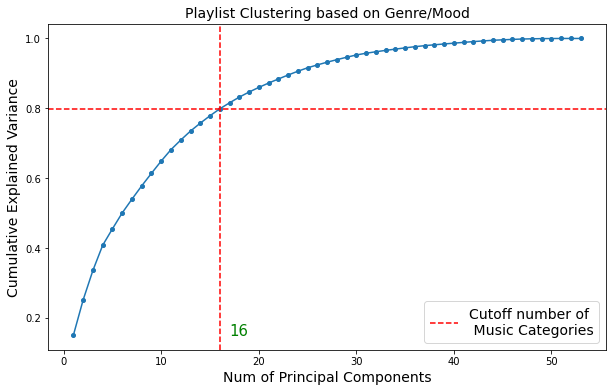

In [344]:
plt.figure(figsize=(10, 6))
plt.plot(nums_of_pc, cumsum_explained_vars, marker='o', markersize=4)
plt.axhline(0.79847785, linestyle='--', color='red', label='Cutoff number of \n Music Categories')
plt.axvline(16, linestyle='--', color='red')
plt.xlabel('Num of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.annotate("16", xy=(17, 0.15), fontsize=15, color='green')
plt.title('Playlist Clustering based on Genre/Mood', fontsize=14)
plt.legend( fontsize=14)
plt.savefig(file_path + 'pca_cluster_cutoff.png', dpi=300,facecolor='white', transparent=False, bbox_inches = 'tight');

In [345]:
pca_playlist = PCA(n_components=16, random_state=24)
pca_playlist.fit_transform(df[mood_genre_cols])

array([[-1.89984152e-01, -2.27060343e-01,  2.48299593e-01, ...,
        -1.56723058e-01, -7.54540791e-02, -5.07103840e-02],
       [-4.59221498e-01, -8.54594390e-01,  1.86253330e-01, ...,
         3.73307415e-02, -2.94551278e-02,  5.42879533e-02],
       [-1.14714368e-01, -2.40520958e-02, -1.80868044e-01, ...,
        -1.27034029e-01, -2.78713142e-01, -3.79128828e-01],
       ...,
       [ 4.56748894e-01,  1.32555779e-01,  7.73708568e-02, ...,
         4.76717354e-01, -1.95127581e-01,  3.14367340e-02],
       [ 1.18818948e+00,  4.64845193e-02,  1.84937953e-01, ...,
         6.42441505e-04, -6.13842576e-03, -1.51633645e-02],
       [ 1.18818948e+00,  4.64845193e-02,  1.84937953e-01, ...,
         6.42441505e-04, -6.13842576e-03, -1.51633645e-02]])

In [346]:
loading_scores = pd.DataFrame(pca_playlist.components_.T, 
                              index=mood_genre_cols, 
                             columns=['PC%s' % _ for _ in range(1, 17)])
loading_scores

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
mood_-,-0.001,-0.001,-0.004,-0.006,-0.002,-0.000,0.002,0.001,0.003,-0.001,-0.003,0.010,0.005,0.000,0.006,0.009
mood_Aggressive,-0.011,-0.009,0.000,-0.053,-0.026,-0.006,-0.012,0.033,0.007,-0.062,0.075,0.077,0.147,-0.030,0.277,0.047
mood_Brooding,-0.048,0.123,0.010,0.007,0.068,-0.140,0.089,0.065,0.189,0.146,0.026,0.052,0.543,0.551,-0.181,0.030
mood_Cool,0.022,-0.001,-0.011,-0.049,-0.041,-0.006,-0.066,-0.129,0.091,-0.015,-0.208,0.055,0.164,-0.096,-0.130,0.107
mood_Defiant,0.683,0.037,0.118,0.259,0.118,0.040,0.134,0.319,-0.171,0.084,0.368,-0.009,-0.201,0.075,0.008,-0.018
mood_Easygoing,-0.003,-0.000,-0.008,-0.007,-0.001,0.004,0.011,-0.004,0.002,0.010,0.002,0.008,0.004,-0.006,-0.002,0.001
mood_Empowering,-0.072,-0.033,-0.258,-0.020,0.706,-0.142,-0.313,-0.151,-0.172,-0.282,-0.004,-0.117,-0.141,-0.022,-0.017,-0.155
mood_Energizing,-0.022,-0.068,-0.112,-0.020,-0.247,-0.141,-0.052,-0.152,0.624,-0.139,0.244,-0.393,-0.327,0.098,0.152,-0.099
mood_Excited,-0.254,-0.406,0.683,0.179,0.121,0.083,0.008,-0.054,-0.058,0.148,-0.235,-0.054,-0.254,0.113,-0.003,0.040
mood_Fiery,-0.002,-0.003,-0.005,-0.000,-0.003,-0.001,0.002,0.001,0.004,-0.001,0.001,0.013,0.004,-0.004,-0.002,-0.001


In [347]:
five_top_feature_cluster = loading_scores.apply(lambda s: pd.Series(s.nlargest(5).index))
five_top_feature_cluster
# five_top_feature_cluster

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,mood_Defiant,genre_Indie Rock,mood_Excited,genre_Pop,mood_Empowering,mood_Yearning,genre_Country & Folk,genre_Alternative,mood_Energizing,genre_Rock,genre_Dance & House,genre_Latin,mood_Brooding,mood_Brooding,genre_Electronica,genre_R&B
1,genre_Rap,mood_Yearning,genre_Dance & House,genre_Indie Rock,genre_Religious,genre_Rock,mood_Upbeat,mood_Defiant,genre_Latin,mood_Excited,mood_Defiant,mood_Lively,genre_Dance & House,genre_Religious,mood_Aggressive,genre_Religious
2,mood_Cool,mood_Brooding,genre_Indie Rock,mood_Defiant,genre_Rock,genre_Country & Folk,mood_Defiant,mood_Urgent,mood_Brooding,mood_Brooding,mood_Energizing,mood_Romantic,genre_Rap,genre_Electronica,mood_Energizing,mood_Urgent
3,genre_Metal,mood_Defiant,genre_Rap,mood_Yearning,genre_Indie Rock,mood_Upbeat,mood_Brooding,genre_Punk,mood_Urgent,mood_Sensual,genre_Rock,genre_Soundtrack,genre_Pop,genre_R&B,genre_Punk,genre_Punk
4,genre_Punk,mood_Melancholy,mood_Defiant,mood_Excited,mood_Excited,genre_Alternative,genre_Indie Rock,mood_Brooding,genre_Alternative,mood_Defiant,genre_Indie Rock,genre_Electronica,mood_Cool,mood_Yearning,mood_Urgent,mood_Cool


In [348]:
playlist_style = ['Defiant Hip-Hop', 'Indie Pop', 'Chill Indie Dance', 'Pop & Rock', 'Christian Rock', 
 'Upbeat Country Rock', 'Aggresive Folk Punk', 'Power Alternative',  'Lantin Dance', 'Slow Rock', 
 'Enegery Dance', 'Lantin Ballad', 'Hip-Hop Dance', 'Mixed Music', 'Electronica Beat', 
 'Contemporary R&B/Funk']
len(playlist_style)

16

In [349]:
playlist_groups = pd.DataFrame(pca_playlist.components_.T, 
                              index=mood_genre_cols, 
                             columns=playlist_style)
pca_results = playlist_groups.apply(lambda s: pd.Series(s.nlargest(5).index))
pca_results.to_csv(file_path + 'pca_results.csv')
pca_results

,Defiant Hip-Hop,Indie Pop,Chill Indie Dance,Pop & Rock,Christian Rock,Upbeat Country Rock,Aggresive Folk Punk,Power Alternative,Lantin Dance,Slow Rock,Enegery Dance,Lantin Ballad,Hip-Hop Dance,Mixed Music,Electronica Beat,Contemporary R&B/Funk
0,mood_Defiant,genre_Indie Rock,mood_Excited,genre_Pop,mood_Empowering,mood_Yearning,genre_Country & Folk,genre_Alternative,mood_Energizing,genre_Rock,genre_Dance & House,genre_Latin,mood_Brooding,mood_Brooding,genre_Electronica,genre_R&B
1,genre_Rap,mood_Yearning,genre_Dance & House,genre_Indie Rock,genre_Religious,genre_Rock,mood_Upbeat,mood_Defiant,genre_Latin,mood_Excited,mood_Defiant,mood_Lively,genre_Dance & House,genre_Religious,mood_Aggressive,genre_Religious
2,mood_Cool,mood_Brooding,genre_Indie Rock,mood_Defiant,genre_Rock,genre_Country & Folk,mood_Defiant,mood_Urgent,mood_Brooding,mood_Brooding,mood_Energizing,mood_Romantic,genre_Rap,genre_Electronica,mood_Energizing,mood_Urgent
3,genre_Metal,mood_Defiant,genre_Rap,mood_Yearning,genre_Indie Rock,mood_Upbeat,mood_Brooding,genre_Punk,mood_Urgent,mood_Sensual,genre_Rock,genre_Soundtrack,genre_Pop,genre_R&B,genre_Punk,genre_Punk
4,genre_Punk,mood_Melancholy,mood_Defiant,mood_Excited,mood_Excited,genre_Alternative,genre_Indie Rock,mood_Brooding,genre_Alternative,mood_Defiant,genre_Indie Rock,genre_Electronica,mood_Cool,mood_Yearning,mood_Urgent,mood_Cool


In [350]:
for col in playlist_groups.columns:
    music_style_dict = playlist_groups[col].to_dict()
    df['music_type_{}'.format(col)] = df[mood_genre_cols].values.dot(np.array(list(music_style_dict.values())))

In [351]:
df.columns.values 

array(['playlist_uri', 'owner', 'streams', 'stream30s', 'dau', 'wau',
       'mau', 'mau_previous_month', 'mau_both_months', 'users',
       'skippers', 'owner_country', 'n_tracks', 'n_local_tracks',
       'n_artists', 'n_albums', 'monthly_stream30s',
       'monthly_owner_stream30s', 'tokens', 'genre_1', 'genre_2',
       'genre_3', 'mood_1', 'mood_2', 'mood_3', 'owner_type',
       'pct_stream30s', 'stream_per_dau', 'stream_per_mau',
       'month_to_month_retention', 'monthly_non_owner_stream30s',
       'pct_non_owner_monthly', 'plst_share_monthly_streams30s',
       'plst_share_daily_streams30s', 'perc_skippers', 'genre_-',
       'genre_Alternative', 'genre_Blues', "genre_Children's",
       'genre_Classical', 'genre_Country & Folk', 'genre_Dance & House',
       'genre_Easy Listening', 'genre_Electronica', 'genre_Holiday',
       'genre_Indie Rock', 'genre_Jazz', 'genre_Latin', 'genre_Metal',
       'genre_New Age', 'genre_Other', 'genre_Pop', 'genre_Punk',
       'genre_R&B', 

In [352]:
music_type_cols = df.columns[-16:]
df['music_type'] = df[music_type_cols].idxmax(axis=1)

In [353]:
df['music_type'] = df['music_type'].apply(lambda x: x.replace('music_type_', ''))
df.head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,...,music_type_Power Alternative,music_type_Lantin Dance,music_type_Slow Rock,music_type_Enegery Dance,music_type_Lantin Ballad,music_type_Hip-Hop Dance,music_type_Mixed Music,music_type_Electronica Beat,music_type_Contemporary R&B/Funk,music_type
0,spotify:user:36069af6af076ccd9e597184a67b68c9:...,36069af6af076ccd9e597184a67b68c9,27,27,1,1,3,3,0,8,...,0.044,-0.057,-0.405,0.527,-0.053,0.362,-0.158,-0.114,-0.121,Enegery Dance
1,spotify:user:d1144a65b1c31c5f9f56b94f831124d5:...,d1144a65b1c31c5f9f56b94f831124d5,0,0,0,1,2,1,1,3,...,-0.085,-0.079,0.231,-0.218,-0.078,-0.088,0.038,-0.063,-0.016,Pop & Rock
2,spotify:user:6b7fbed9edd6418ddd3b555bba441536:...,6b7fbed9edd6418ddd3b555bba441536,4,2,1,1,7,5,0,15,...,0.004,0.270,-0.017,-0.017,0.951,-0.381,-0.127,-0.315,-0.449,Lantin Ballad
3,spotify:user:580b98725077a94c3c8d01d07390426b:...,580b98725077a94c3c8d01d07390426b,12,12,1,1,4,6,1,10,...,-0.017,-0.119,-0.257,0.297,-0.117,0.102,-0.047,-0.133,-0.086,Chill Indie Dance
4,spotify:user:1305d39070c95d161cc502e15014897d:...,1305d39070c95d161cc502e15014897d,20,4,1,1,2,1,1,2,...,-0.127,0.003,0.226,-0.159,-0.148,-0.296,-0.034,-0.021,-0.060,Chill Indie Dance


## Data Exploration

In [355]:
df['music_type'].value_counts().index

Index(['Defiant Hip-Hop', 'Pop & Rock', 'Indie Pop', 'Chill Indie Dance',
       'Lantin Ballad', 'Slow Rock', 'Christian Rock', 'Aggresive Folk Punk',
       'Electronica Beat', 'Power Alternative', 'Lantin Dance',
       'Upbeat Country Rock', 'Contemporary R&B/Funk', 'Enegery Dance',
       'Hip-Hop Dance', 'Mixed Music'],
      dtype='object')

In [ ]:
plst_count = df.groupby(['music_type']).agg({'playlist_uri':'nunique'}).apply(lambda x: np.round(x*100/x.sum(), 2))\
                                .sort_values('playlist_uri', ascending=False).reset_index()
plst_sample = df.groupby(['music_type'], as_index=False).apply(lambda x: x.sort_values('mau', ascending=False).sample(1))
# plst_summary_by_music_type = plst_count.merge(plst_sample, left_on = 
# plst_sample['Playlist Example'] = plst_sample['playlist_uri'].apply(plst_name)
plst_sample = plst_sample[['playlist_uri', 'music_type']].reset_index(0).reset_index(drop=True)
plst_sample['Playlist Example'] = plst_sample['playlist_uri'].apply(plst_name)
plst_sample

In [ ]:
df[(df['tokens'].str.contains("pop")) & (df['music_type']=='Indie Pop')]['playlist_uri'].head(20).apply(plst_name)


In [358]:
plst_count = df.groupby(['music_type']).agg({'playlist_uri':'nunique'}).apply(lambda x: np.round(x*100/x.sum(), 2))\
                                .sort_values('playlist_uri', ascending=False).reset_index()
plst_count

,music_type,playlist_uri
0,Defiant Hip-Hop,16.610
1,Pop & Rock,15.310
2,Indie Pop,13.110
3,Chill Indie Dance,10.310
4,Lantin Ballad,7.060
5,Slow Rock,6.930
6,Christian Rock,5.830
7,Aggresive Folk Punk,4.880
8,Electronica Beat,4.030
9,Power Alternative,3.730


In [359]:
plst_count.to_csv(file_path + 'playlist_by_music_type.csv', index=False)

In [360]:
order = df.groupby('music_type')['dau'].sum().sort_values(ascending=False).index
dau_summary_sp = df.groupby(['owner_type', 'music_type'])['n_tracks', 'n_albums', 'stream30s', 'monthly_stream30s'].sum().reset_index()
dau_summary_sp

,owner_type,music_type,n_tracks,n_albums,stream30s,monthly_stream30s
0,Individual Playlist,Aggresive Folk Punk,4073253,1713762,251078,7537481
1,Individual Playlist,Chill Indie Dance,8626892,4812463,620053,18446730
2,Individual Playlist,Christian Rock,4656541,1815069,274226,9127759
3,Individual Playlist,Contemporary R&B/Funk,1536127,507955,88235,2743647
4,Individual Playlist,Defiant Hip-Hop,15733688,7093563,731465,19492548
5,Individual Playlist,Electronica Beat,3387967,1178958,141488,4267936
6,Individual Playlist,Enegery Dance,1454496,746075,109219,3004457
7,Individual Playlist,Hip-Hop Dance,445446,146126,27498,833135
8,Individual Playlist,Indie Pop,12167481,5459656,371087,12491541
9,Individual Playlist,Lantin Ballad,5284913,1120610,624196,18587394


In [364]:
music_type_summary = pd.pivot_table(df, values=['playlist_uri', 'dau', 'wau', 'mau', 'stream30s', \
                           'monthly_stream30s', 'monthly_owner_stream30s',  'n_tracks', \
                           'n_artists', 'n_albums'], index=['music_type'],
                    aggfunc={'playlist_uri':'nunique',  'dau':'sum', 'wau':'sum', 'mau':'sum', 'stream30s':'sum', \
                           'monthly_stream30s':'sum', 'monthly_owner_stream30s': 'sum', 'n_tracks':'sum', \
                           'n_artists':'sum', 'n_albums':'sum'}, margins=True)
music_type_summary = music_type_summary.div( music_type_summary.iloc[-1,:], axis=1 )*100
sum_cols = ['playlist_uri', 'dau', 'wau', 'mau', 'stream30s', \
                           'monthly_stream30s','monthly_owner_stream30s', 'n_tracks', \
                           'n_artists', 'n_albums']
music_type_summary = music_type_summary[sum_cols].sort_values(by=['playlist_uri'], ascending=False).drop('All')
music_type_summary

,playlist_uri,dau,wau,mau,stream30s,monthly_stream30s,monthly_owner_stream30s,n_tracks,n_artists,n_albums
music_type,,,,,,,,,,
Defiant Hip-Hop,16.605,8.575,7.603,7.469,7.533,7.298,17.978,19.362,22.041,19.938
Pop & Rock,15.310,39.348,36.518,35.782,41.748,39.054,17.367,13.293,15.409,15.440
Indie Pop,13.110,11.612,15.053,14.609,12.666,15.026,12.498,14.981,13.892,15.358
Chill Indie Dance,10.313,12.102,10.058,10.422,10.353,9.095,10.144,10.619,13.224,13.528
Lantin Ballad,7.064,5.194,5.928,6.225,5.899,6.371,7.362,6.505,4.048,3.152
Slow Rock,6.935,5.094,5.602,5.812,4.527,4.689,6.007,7.444,6.771,6.898
Christian Rock,5.827,2.038,2.032,2.009,2.128,2.333,6.027,5.731,4.711,5.102
Aggresive Folk Punk,4.880,4.557,4.534,4.340,4.905,5.374,5.285,5.015,4.685,4.821
Electronica Beat,4.034,2.233,2.558,2.832,1.907,2.087,3.416,4.171,3.188,3.317


In [368]:
music_type_summary_snapshot = music_type_summary[['playlist_uri', 'n_tracks',  'stream30s', 'monthly_stream30s']]
compressed_summary = pd.melt(music_type_summary_snapshot.reset_index()
                     , id_vars='music_type').rename(columns={'variable':'Metric', 'value':'Share'})
# compressed_summary2 = pd.melt(music_type_summary_snapshot2.sort_values(by='monthly_stream30s', ascending=False).reset_index()
#                      , id_vars='music_type').rename(columns={'variable':'Metric', 'value':'Share'})
compressed_summary['Metric'] = compressed_summary['Metric'].map({'playlist_uri':'# of Playlists', \
                                                                 'monthly_stream30s': '# of Monthly Streams (>30s)', \
                                                                 'n_tracks':'# of Tracks', \
                                                                'stream30s': '# of Streams (>30s)',})
# compressed_summary1
# compressed_summary = pd.concat([compressed_summary1, compressed_summary2]).reset_index()
compressed_summary

,music_type,Metric,Share
0,Defiant Hip-Hop,# of Playlists,16.605
1,Pop & Rock,# of Playlists,15.310
2,Indie Pop,# of Playlists,13.110
3,Chill Indie Dance,# of Playlists,10.313
4,Lantin Ballad,# of Playlists,7.064
...,...,...,...
59,Upbeat Country Rock,# of Monthly Streams (>30s),0.882
60,Contemporary R&B/Funk,# of Monthly Streams (>30s),1.249
61,Enegery Dance,# of Monthly Streams (>30s),2.328
62,Hip-Hop Dance,# of Monthly Streams (>30s),0.218


In [366]:
music_type_order = order = df.groupby('music_type')['playlist_uri'].nunique().sort_values(ascending=False).index
streams_order = order = df.groupby('music_type')['monthly_stream30s'].sum().sort_values(ascending=False).index

In [367]:
fig = px.bar(compressed_summary,x='Metric', y='Share', color='music_type'
             , category_orders= {"music_type": music_type_order}
             , labels={"music_type":"Music Type"}
#              , category_orders={"n_tracks": plst_order,
#                                 "n_artists": plst_order,
#                                 'stream30s':streams_order,
#                                'monthly_stream30s':streams_order}
            , title="Playlist & Listener Metrics by Music Type"
             , template='plotly_white'
)
fig.update_layout(xaxis_title=None, yaxis_title='Percentage Share', font=dict(
        # family="Courier New, monospace",
        size=18,  # Set the font size here
        # color="RebeccaPurple"
    ))
fig.write_image(file_path + "metrics_by_music_type.png")
fig.show()

In [1048]:
music_type_summary_sp = pd.pivot_table(df[df['owner_type']=='Spotify'], values=['playlist_uri', 'dau', 'wau', 'mau', 'stream30s', \
                           'monthly_stream30s', 'n_tracks', \
                           'n_artists', 'n_albums'], index=['music_type'],
                    aggfunc={'playlist_uri':'nunique',  'dau':'sum', 'wau':'sum', 'mau':'sum', 'stream30s':'sum', \
                           'monthly_stream30s':'sum', 'n_tracks':'sum', \
                           'n_artists':'sum', 'n_albums':'sum'}, margins=True)
music_type_summary_sp = music_type_summary_sp.div( music_type_summary_sp.iloc[-1,:], axis=1 )*100
sum_cols = ['playlist_uri', 'dau', 'wau', 'mau', 'stream30s', \
                           'monthly_stream30s', 'n_tracks', \
                           'n_artists', 'n_albums']
music_type_summary_sp = music_type_summary_sp[sum_cols].sort_values(by=['playlist_uri'], ascending=False).drop('All')
music_type_summary_sp

,playlist_uri,dau,wau,mau,stream30s,monthly_stream30s,n_tracks,n_artists,n_albums
music_type,,,,,,,,,
Indie Pop,18.296,13.159,17.599,16.909,14.601,17.477,22.566,23.517,24.091
Pop & Rock,17.043,47.758,42.188,40.654,51.435,47.742,15.994,18.319,18.055
Aggresive Folk Punk,9.273,4.533,4.534,4.388,4.792,5.411,7.106,7.842,7.911
Chill Indie Dance,8.521,11.866,9.595,10.080,9.390,7.601,9.635,7.579,7.413
Electronica Beat,8.020,1.871,2.363,2.702,1.511,1.734,5.290,5.658,5.733
Slow Rock,7.769,3.938,4.615,5.022,3.142,3.535,8.040,6.526,6.640
Defiant Hip-Hop,5.514,5.364,5.212,5.505,4.580,4.817,6.116,7.013,6.687
Lantin Ballad,5.514,3.024,3.908,4.052,3.174,3.775,6.292,4.702,4.563
Power Alternative,4.762,3.014,3.587,3.950,2.297,2.591,4.256,4.473,4.627


In [1049]:
music_type_summary_spn = pd.pivot_table(df[df['owner_type']!='Spotify'], values=['playlist_uri', 'dau', 'wau', 'mau', 'stream30s', \
                           'monthly_stream30s', 'n_tracks', \
                           'n_artists', 'n_albums'], index=['music_type'],
                    aggfunc={'playlist_uri':'nunique',  'dau':'sum', 'wau':'sum', 'mau':'sum', 'stream30s':'sum', \
                           'monthly_stream30s':'sum', 'n_tracks':'sum', \
                           'n_artists':'sum', 'n_albums':'sum'}, margins=True)
music_type_summary_spn = music_type_summary_spn.div( music_type_summary_spn.iloc[-1,:], axis=1 )*100
sum_cols = ['playlist_uri', 'dau', 'wau', 'mau', 'stream30s', \
                           'monthly_stream30s', 'n_tracks', \
                           'n_artists', 'n_albums']
music_type_summary_spn = music_type_summary_spn[sum_cols].sort_values(by=['playlist_uri'], ascending=False).drop('All')
music_type_summary_spn

,playlist_uri,dau,wau,mau,stream30s,monthly_stream30s,n_tracks,n_artists,n_albums
music_type,,,,,,,,,
Defiant Hip-Hop,16.616,16.885,15.095,14.253,15.138,13.652,19.368,22.052,19.946
Pop & Rock,15.308,17.578,18.750,18.950,16.798,16.806,13.292,15.407,15.438
Indie Pop,13.105,7.607,7.074,6.663,7.680,8.749,14.978,13.886,15.352
Chill Indie Dance,10.315,12.712,11.508,11.606,12.832,12.920,10.619,13.228,13.532
Lantin Ballad,7.065,10.810,12.256,13.733,12.918,13.018,6.506,4.047,3.151
Slow Rock,6.934,8.086,8.696,8.541,8.094,7.643,7.443,6.772,6.898
Christian Rock,5.829,5.195,5.550,5.710,5.675,6.393,5.732,4.712,5.104
Aggresive Folk Punk,4.876,4.618,4.532,4.174,5.196,5.279,5.014,4.683,4.819
Electronica Beat,4.030,3.170,3.167,3.280,2.928,2.989,4.170,3.186,3.315


In [1050]:
sp_music_type_summary_snapshot = music_type_summary_sp[['playlist_uri', 'n_tracks',  'stream30s', 'monthly_stream30s']]
sp_compressed_summary = pd.melt(sp_music_type_summary_snapshot.reset_index()
                     , id_vars='music_type').rename(columns={'variable':'Metric', 'value':'Share'})
# compressed_summary2 = pd.melt(music_type_summary_snapshot2.sort_values(by='monthly_stream30s', ascending=False).reset_index()
#                      , id_vars='music_type').rename(columns={'variable':'Metric', 'value':'Share'})
sp_compressed_summary['Metric'] = sp_compressed_summary['Metric'].map({'playlist_uri':'# of Playlists', \
                                                                 'monthly_stream30s': '# of Monthly Streams (>30s)', \
                                                                 'n_tracks':'# of Tracks', \
                                                                'stream30s': '# of Streams (>30s)',})
# compressed_summary1
# compressed_summary = pd.concat([compressed_summary1, compressed_summary2]).reset_index()
sp_compressed_summary

,music_type,Metric,Share
0,Indie Pop,# of Playlists,18.296
1,Pop & Rock,# of Playlists,17.043
2,Aggresive Folk Punk,# of Playlists,9.273
3,Chill Indie Dance,# of Playlists,8.521
4,Electronica Beat,# of Playlists,8.020
...,...,...,...
59,Upbeat Country Rock,# of Monthly Streams (>30s),0.584
60,Contemporary R&B/Funk,# of Monthly Streams (>30s),0.986
61,Lantin Dance,# of Monthly Streams (>30s),0.471
62,Hip-Hop Dance,# of Monthly Streams (>30s),0.076


In [1051]:
spn_music_type_summary_snapshot = music_type_summary_spn[['playlist_uri', 'n_tracks',  'stream30s', 'monthly_stream30s']]
spn_compressed_summary = pd.melt(spn_music_type_summary_snapshot.reset_index()
                     , id_vars='music_type').rename(columns={'variable':'Metric', 'value':'Share'})
# compressed_summary2 = pd.melt(music_type_summary_snapshot2.sort_values(by='monthly_stream30s', ascending=False).reset_index()
#                      , id_vars='music_type').rename(columns={'variable':'Metric', 'value':'Share'})
spn_compressed_summary['Metric'] = spn_compressed_summary['Metric'].map({'playlist_uri':'# of Playlists', \
                                                                 'monthly_stream30s': '# of Monthly Streams (>30s)', \
                                                                 'n_tracks':'# of Tracks', \
                                                                'stream30s': '# of Streams (>30s)',})
# compressed_summary1
# compressed_summary = pd.concat([compressed_summary1, compressed_summary2]).reset_index()
spn_compressed_summary

,music_type,Metric,Share
0,Defiant Hip-Hop,# of Playlists,16.616
1,Pop & Rock,# of Playlists,15.308
2,Indie Pop,# of Playlists,13.105
3,Chill Indie Dance,# of Playlists,10.315
4,Lantin Ballad,# of Playlists,7.065
...,...,...,...
59,Upbeat Country Rock,# of Monthly Streams (>30s),1.646
60,Contemporary R&B/Funk,# of Monthly Streams (>30s),1.922
61,Enegery Dance,# of Monthly Streams (>30s),2.104
62,Hip-Hop Dance,# of Monthly Streams (>30s),0.584


In [1052]:
fig = px.bar(spn_compressed_summary,x='Metric', y='Share', color='music_type'
             , category_orders= {"Metrics": plst_order}
             , labels={"music_type":"Music Type"}
#              , category_orders={"n_tracks": plst_order,
#                                 "n_artists": plst_order,
#                                 'stream30s':streams_order,
#                                'monthly_stream30s':streams_order}
            , title="Individual Playlist & Listener Metrics by Music Type"
             , template='plotly_white'
)
fig.update_layout(xaxis_title=None, yaxis_title='Percentage Share', font=dict(
        # family="Courier New, monospace",
        size=18,  # Set the font size here
        # color="RebeccaPurple"
    ))
fig.write_image(file_path + "ind_playlist_metrics_by_music_type2.png")
fig.show()

In [1053]:
fig = px.bar(sp_compressed_summary,x='Metric', y='Share', color='music_type'
             , category_orders= {"Metrics": plst_order}
             , labels={"music_type":"Music Type"}
#              , category_orders={"n_tracks": plst_order,
#                                 "n_artists": plst_order,
#                                 'stream30s':streams_order,
#                                'monthly_stream30s':streams_order}
            , title="Spotify Playlist & Listener Metrics by Music Type"
             , template='plotly_white'
)
fig.update_layout(xaxis_title=None, yaxis_title='Percentage Share', font=dict(
        # family="Courier New, monospace",
        size=18,  # Set the font size here
        # color="RebeccaPurple"
    ))
fig.write_image(file_path + "spotify_metrics_by_music_type2.png")
fig.show()

In [1054]:
music_type_summary_snapshot1 = music_type_summary[['n_tracks', 'n_artists', 'dau', 'mau']]
compressed_summary1 = pd.melt(music_type_summary_snapshot1.reset_index()
                     , id_vars='music_type').rename(columns={'variable':'Metric', 'value':'Share'})
# compressed_summary2 = pd.melt(music_type_summary_snapshot2.sort_values(by='monthly_stream30s', ascending=False).reset_index()
#                      , id_vars='music_type').rename(columns={'variable':'Metric', 'value':'Share'})
compressed_summary1['Metric'] = compressed_summary1['Metric'].map({'n_artists':'# of Artists', \
                                                                 'dau': 'DAU', \
                                                                 'n_tracks':'# of Tracks', \
                                                                'mau': 'MAU',})
# compressed_summary1
# compressed_summary = pd.concat([compressed_summary1, compressed_summary2]).reset_index()
compressed_summary1

,music_type,Metric,Share
0,Defiant Hip-Hop,# of Tracks,19.362
1,Pop & Rock,# of Tracks,13.293
2,Indie Pop,# of Tracks,14.981
3,Chill Indie Dance,# of Tracks,10.619
4,Lantin Ballad,# of Tracks,6.505
...,...,...,...
59,Upbeat Country Rock,MAU,0.872
60,Contemporary R&B/Funk,MAU,1.275
61,Enegery Dance,MAU,2.987
62,Hip-Hop Dance,MAU,0.217


In [1055]:
fig = px.bar(compressed_summary1,x='Metric', y='Share', color='music_type'
             , category_orders= {"Metrics": plst_order}
             , labels={"music_type":"Music Type"}
#              , category_orders={"n_tracks": plst_order,
#                                 "n_artists": plst_order,
#                                 'stream30s':streams_order,
#                                'monthly_stream30s':streams_order}
            , title="Playlist & Listener Metrics by Music Type"
             , template='plotly_white'
)
fig.update_layout(xaxis_title=None, yaxis_title='Percentage Share', font=dict(
        # family="Courier New, monospace",
        size=18,  # Set the font size here
        # color="RebeccaPurple"
    ))
fig.write_image(file_path + "metrics_by_music_type2.png")
fig.show()

In [1058]:
streams_summary_sp = df[df['owner']=='spotify'].groupby('music_type')['stream30s'].sum() \
                .to_frame('# of Streams (>30s)').reset_index().sort_values(by='# of Streams (>30s)', ascending=False)
streams_summary_spn = df[df['owner']!='spotify'].groupby('music_type')['stream30s'].sum() \
                .to_frame('# of Streams (>30s)').reset_index().sort_values(by='# of Streams (>30s)', ascending=False)
mau_streams_summary_sp = df[df['owner']=='spotify'].groupby('music_type')['monthly_stream30s'].sum() \
                .to_frame('# of Monthly Streams (>30s)').reset_index().sort_values(by='# of Monthly Streams (>30s)', ascending=False)
mau_streams_summary_spn = df[df['owner']!='spotify'].groupby('music_type')['monthly_stream30s'].sum() \
                .to_frame('# of Monthly Streams (>30s)').reset_index().sort_values(by='# of Monthly Streams (>30s)', ascending=False)
plst_summary_sp = df[df['owner']=='spotify'].groupby('music_type')['playlist_uri'].nunique() \
                .to_frame('# of Playlist').reset_index().sort_values(by='# of Playlist', ascending=False)
plst_summary_spn = df[df['owner']!='spotify'].groupby('music_type')['playlist_uri'].nunique() \
                .to_frame('# of Playlist').reset_index().sort_values(by='# of Playlist', ascending=False)
n_tracks_sp = df[df['owner']=='spotify'].groupby('music_type')['n_tracks'].sum() \
                .to_frame('# of Tracks').reset_index().sort_values(by='# of Tracks', ascending=False)
n_tracks_spn = df[df['owner']!='spotify'].groupby('music_type')['n_tracks'].sum() \
                .to_frame('# of Tracks').reset_index().sort_values(by='# of Tracks', ascending=False)
fig = make_subplots(rows=2, cols=1, x_title='# of Monthly Streams (>30s)', y_title='Music Type')

fig.add_trace(go.Bar(y=mau_streams_summary_sp['music_type'][::-1], x=mau_streams_summary_sp['# of Monthly Streams (>30s)'][::-1], orientation='h', name='Spotify Playlist'),
              row=1, col=1)
fig.add_trace(go.Bar(y=mau_streams_summary_spn['music_type'][::-1], x=mau_streams_summary_spn['# of Monthly Streams (>30s)'][::-1], orientation='h', name='Individual Playlist'),
              row=2, col=1)

fig.update_layout(font_size=18, title='Monthly Streams Distribution by Music Type')
fig.write_image(file_path + "mau_streams_distribution_by_music_type.png")

fig.show()

In [1059]:
fig = make_subplots(rows=2, cols=1, x_title='# of Playlist', y_title='Music Type')

fig.add_trace(go.Bar(y=plst_summary_sp['music_type'][::-1], x=plst_summary_sp['# of Playlist'][::-1], orientation='h', name='Spotify Playlist'),
              row=1, col=1)
fig.add_trace(go.Bar(y=plst_summary_spn['music_type'][::-1], x=plst_summary_spn['# of Playlist'][::-1], orientation='h', name='Individual Playlist'),
              row=2, col=1)

fig.update_layout(font_size=18, title='Playlist Volume Distribution by Music Type')
fig.write_image(file_path + "distribution_by_music_type_playlist.png")

fig.show()

In [1060]:
fig = make_subplots(rows=2, cols=1, x_title='# of Tracks', y_title='Music Type')

fig.add_trace(go.Bar(y=n_tracks_sp['music_type'][::-1], x=n_tracks_sp['# of Tracks'][::-1], orientation='h', name='Spotify Playlist'),
              row=1, col=1)
fig.add_trace(go.Bar(y=n_tracks_spn['music_type'][::-1], x=n_tracks_spn['# of Tracks'][::-1], orientation='h', name='Individual Playlist'),
              row=2, col=1)

fig.update_layout(font_size=18, title='Track Volume Distribution by Music Type')
fig.write_image(file_path + "distribution_by_music_type_tracks.png")

fig.show()

In [1061]:
def stream_per_mau(df_sub):
    return df_sub['monthly_stream30s'].sum() / float(df_sub['mau'].sum())
def mom_retention(df_sub):
    return df_sub['mau_both_months'].sum() / float(df_sub['mau_previous_month'].sum())

In [1062]:
# df.columns.values

In [1063]:
stream_mau_summary_sp = df[df['owner']=='spotify'].groupby('music_type').apply(stream_per_mau) \
                .to_frame('Stream Per MAU').reset_index().sort_values(by='Stream Per MAU', ascending=False)
stream_mau_summary_spn = df[df['owner']!='spotify'].groupby('music_type').apply(stream_per_mau)  \
                .to_frame('Stream Per MAU').reset_index().sort_values(by='Stream Per MAU', ascending=False)
mom_sp = df[df['owner']=='spotify'].groupby('music_type').apply(mom_retention) \
                .to_frame('MOM Active User Retention').reset_index().sort_values(by='MOM Active User Retention', ascending=False)
mom_spn = df[df['owner']!='spotify'].groupby('music_type').apply(mom_retention) \
                .to_frame('MOM Active User Retention').reset_index().sort_values(by='MOM Active User Retention', ascending=False)

In [1064]:
stream_mau_summary_sp

,music_type,Stream Per MAU
0,Aggresive Folk Punk,21.791
12,Pop & Rock,20.753
8,Indie Pop,18.266
9,Lantin Ballad,16.465
3,Contemporary R&B/Funk,15.999
4,Defiant Hip-Hop,15.463
15,Upbeat Country Rock,15.053
11,Mixed Music,14.408
2,Christian Rock,14.098
6,Enegery Dance,13.657


In [1065]:
fig = make_subplots(rows=2, cols=1, x_title='Streams Per MAU', y_title='Music Type')

fig.add_trace(go.Bar(y=stream_mau_summary_sp['music_type'][::-1], x=stream_mau_summary_sp['Stream Per MAU'][::-1], orientation='h', name='Spotify Playlist'),
              row=1, col=1)
fig.add_trace(go.Bar(y=stream_mau_summary_spn['music_type'][::-1], x=stream_mau_summary_spn['Stream Per MAU'][::-1], orientation='h', name='Individual Playlist'),
              row=2, col=1)

fig.update_layout(font_size=18, title='Stream Per MAU Distribution by Music Type')
# fig.write_image(file_path + "stream_mau_distribution_by_music_type.png")

fig.show()

In [1068]:
fig = make_subplots(rows=2, cols=1, x_title='MOM Active User Retention', y_title='Music Type')

fig.add_trace(go.Bar(y=mom_sp['music_type'][::-1], x=mom_sp['MOM Active User Retention'][::-1], orientation='h', name='Spotify Playlist'),
              row=1, col=1)
fig.add_trace(go.Bar(y=mom_spn['music_type'][::-1], x=mom_spn['MOM Active User Retention'][::-1], orientation='h', name='Individual Playlist'),
              row=2, col=1)

fig.update_layout(font_size=18, title='MOM Active User Retention Distribution by Music Type')
# fig.write_image(file_path + "stream_mau_distribution_by_music_type.png")

fig.show()

In [1071]:
music_type_summary = pd.pivot_table(df, values=['playlist_uri', 'dau', 'wau', 'mau', 'stream30s', \
                           'monthly_stream30s', 'n_tracks', \
                           'n_artists', 'n_albums'], index=['music_type'],
                    aggfunc={'playlist_uri':'nunique',  'dau':'sum', 'wau':'sum', 'mau':'sum', 'stream30s':'sum', \
                           'monthly_stream30s':'sum', 'n_tracks':'sum', \
                           'n_artists':'sum', 'n_albums':'sum'}, margins=True)
music_type_summary = music_type_summary.div( music_type_summary.iloc[-1,:], axis=1 )*100
sum_cols = ['playlist_uri', 'dau', 'wau', 'mau', 'stream30s', \
                           'monthly_stream30s', 'n_tracks', \
                           'n_artists', 'n_albums']
music_type_summary = music_type_summary[sum_cols].sort_values(by=['playlist_uri'], ascending=False).drop('All')
music_type_summary

,playlist_uri,dau,wau,mau,stream30s,monthly_stream30s,n_tracks,n_artists,n_albums
music_type,,,,,,,,,
Defiant Hip-Hop,16.605,8.575,7.603,7.469,7.533,7.298,19.362,22.041,19.938
Pop & Rock,15.310,39.348,36.518,35.782,41.748,39.054,13.293,15.409,15.440
Indie Pop,13.110,11.612,15.053,14.609,12.666,15.026,14.981,13.892,15.358
Chill Indie Dance,10.313,12.102,10.058,10.422,10.353,9.095,10.619,13.224,13.528
Lantin Ballad,7.064,5.194,5.928,6.225,5.899,6.371,6.505,4.048,3.152
Slow Rock,6.935,5.094,5.602,5.812,4.527,4.689,7.444,6.771,6.898
Christian Rock,5.827,2.038,2.032,2.009,2.128,2.333,5.731,4.711,5.102
Aggresive Folk Punk,4.880,4.557,4.534,4.340,4.905,5.374,5.015,4.685,4.821
Electronica Beat,4.034,2.233,2.558,2.832,1.907,2.087,4.171,3.188,3.317


In [1073]:
music_type_summary.sort_values(by=['dau', 'mau', 'stream30s', 'monthly_stream30s', 'n_tracks'], ascending=False).T

music_type,Pop & Rock,Chill Indie Dance,Indie Pop,Defiant Hip-Hop,Lantin Ballad,Slow Rock,Aggresive Folk Punk,Power Alternative,Enegery Dance,Electronica Beat,Christian Rock,Lantin Dance,Contemporary R&B/Funk,Upbeat Country Rock,Hip-Hop Dance,Mixed Music
playlist_uri,15.310,10.313,13.110,16.605,7.064,6.935,4.880,3.734,2.451,4.034,5.827,3.243,2.550,2.598,0.683,0.662
dau,39.348,12.102,11.612,8.575,5.194,5.094,4.557,3.126,2.763,2.233,2.038,1.238,1.004,0.771,0.228,0.118
wau,36.518,10.058,15.053,7.603,5.928,5.602,4.534,3.507,2.846,2.558,2.032,1.319,1.315,0.803,0.208,0.117
mau,35.782,10.422,14.609,7.469,6.225,5.812,4.340,3.752,2.987,2.832,2.009,1.289,1.275,0.872,0.217,0.108
stream30s,41.748,10.353,12.666,7.533,5.899,4.527,4.905,2.625,2.471,1.907,2.128,1.057,1.090,0.768,0.219,0.104
monthly_stream30s,39.054,9.095,15.026,7.298,6.371,4.689,5.374,2.806,2.328,2.087,2.333,1.070,1.249,0.882,0.218,0.120
n_tracks,13.293,10.619,14.981,19.362,6.505,7.444,5.015,4.047,1.791,4.171,5.731,2.239,1.891,2.110,0.548,0.254
n_artists,15.409,13.224,13.892,22.041,4.048,6.771,4.685,3.239,2.169,3.188,4.711,2.637,1.402,1.945,0.410,0.228
n_albums,15.440,13.528,15.358,19.938,3.152,6.898,4.821,3.589,2.099,3.317,5.102,2.560,1.429,2.141,0.411,0.218


## Defining Success

For non-spotify playlist we have 99 quantile of MAU at **128**. We decide to select the **top 1%** playlist as the user base. 
1. Why MAU
    - MAU can infer average DAU, e.g. MAU =128 means we have at least 4 DAU listening to a playlist. If DAU < 4 that means, this playlist would have too few listeners 
    - DAU is only given for day, even if we have a high DAU cutoff, we probably wont have a high MAU due to DAU variation 
    - Spotify users, especially premium users are charged based on monthly basis, therefore MAU would be a better metric to infer user engagement for premium users 

In [36]:
popular_plst = df[df['mau']>=128]

In [37]:
popular_owner_group = popular_plst.groupby(['owner_type'], as_index=False)[group_metrics].agg({'playlist_uri': 'count', 'streams':'mean', 'stream30s':'mean', 'pct_stream30s':'mean', 
                                               'dau':'mean', 'wau':'mean', 'mau':'mean',
                                                       'mau_both_months':'mean', 'monthly_stream30s':'mean', 'monthly_owner_stream30s':'mean', 
                                                        'stream_per_dau':'median', 'stream_per_mau':'median', 'month_to_month_retention':'median'})
popular_owner_group

,owner_type,playlist_uri,streams,stream30s,pct_stream30s,dau,wau,mau,mau_both_months,monthly_stream30s,monthly_owner_stream30s,stream_per_dau,stream_per_mau,month_to_month_retention
0,Individual Playlist,4039,1181.559,629.187,0.600,65.564,335.747,980.243,167.923,17701.418,103.864,8.375,15.164,0.140
1,Spotify,389,51913.866,31993.301,0.657,3304.710,17124.000,53190.609,10276.532,939981.326,1.514,8.165,12.137,0.129


In [38]:
popular_plst.groupby(['owner_type'], as_index=False)[group_metrics].describe(percentiles=[.25, .5, .75, .99])

streams                                                                    \
     count      mean        std   min      25%      50%       75%        99%   
0 4039.000  1181.559   7556.819 0.000  123.000  248.000   521.500  21033.440   
1  389.000 51913.866 201266.588 7.000 1724.000 7155.000 31536.000 591211.920   

              stream30s  ... monthly_stream30s monthly_owner_stream30s  \
          max     count  ...               max                   count   
0  293283.000  4039.000  ...       5098585.000                4039.000   
1 2629715.000   389.000  ...      42497334.000                 389.000   

                                                               
     mean     std   min   25%    50%    75%      99%      max  
0 103.864 334.522 0.000 1.000 12.000 64.000 1566.680 5032.000  
1   1.514   3.745 0.000 0.000  0.000  1.000   15.240   44.000  

[2 rows x 117 columns]

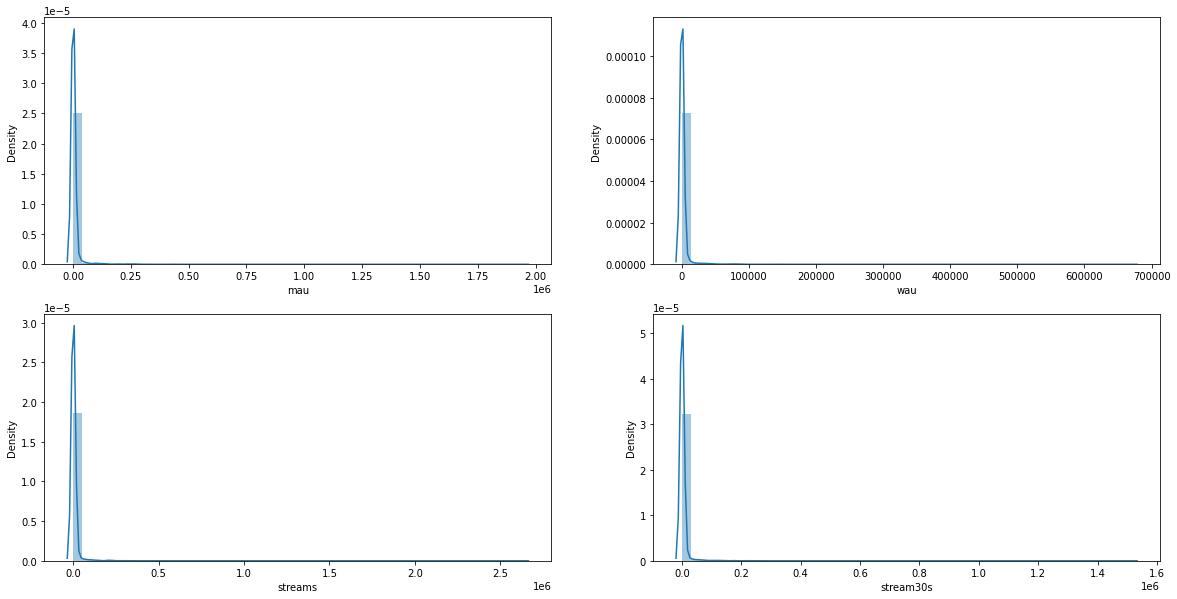

In [ ]:
_, fig = plt.subplots(2, 2, figsize=(20, 10))
sns.distplot(popular_plst['mau'], ax=fig[0][0])
sns.distplot(popular_plst['wau'], ax=fig[0][1])
sns.distplot(popular_plst['streams'], ax=fig[1][0])
sns.distplot(popular_plst['stream30s'], ax=fig[1][1]);

# What makes a playlist successful?

## Clarify the Question

1. What playlist? all playlists?
 
    - Assume we look at all the playlist


2. We only have today's data? 

    - Is this data representative? Insights from this data is conclusive or not? 
    
    - Assume yes -- next step about this later 
    
3. We only focus on Non-Spotify owned playlist?

    - Playlists owned by Spotify have been very successful and popular among listeners 
    - Separate Spotify Plylist and other Playlist and look into them separately
    

## 1. Defining the Goal

The high level goal is to identify factors that makes a playlist successful. The way to define successful from business perspective can be

1. user conversion. User are opening this playlist and listen to this playlist.

2. increase user engagement => users are listening to this platform both shor term and long term

2. increase user retention

3. increase user staisfaction 

4. revenue 

## 2. Success Metric

1. User engagement
    
    A. Short Term
        
        A successful playlist should be a playlist with lots of listeners    

            - DAU Number of Daily Active Users, i.e. users with a stream over 30 seconds from playlist today

            - WAU  

        B. successful playlist should engage listeners to listen more and longer 
   
            - streams per DAU

            - Streams per playlist

            - Streams > 30s per playlist

   B. Long Term
   
    - MAU
    
    - streams per MAU
    
    - Monthly streams > 30s per playlist
    
    - Monthly playlist owner streams > 30s per playlist
    
    - Monthly active user retention per playlist (mau_previous_months, mau_both_months)

In [42]:
popular_plst.columns

Index(['playlist_uri', 'owner', 'streams', 'stream30s', 'dau', 'wau', 'mau',
       'mau_previous_month', 'mau_both_months', 'users',
       ...
       'music_type_Power Alternative', 'music_type_Lantin Dance',
       'music_type_Slow Rock', 'music_type_Enegery Dance',
       'music_type_Lantin Ballad', 'music_type_Hip-Hop Dance',
       'music_type_Mixed Music', 'music_type_Electronica Beat',
       'music_type_Contemporary R&B/Funk', 'music_type'],
      dtype='object', length=105)

### 2.1 Conversion - Short Term

**Success Metrics** 
1. dail % of streams >30s. 
    If dail % of streams >30s >=50, that is saying we have over 50% of streams longer than 30s, we think this is a successful playlist

2. streams per DAU 
    If dail % of streams per DAU  >=median, we think this is a successful playlist

**Guardrail Metrics**
1. DAU

In [44]:
popular_plst['owner_type'] = popular_plst['owner_type'].map({'Individual Playlist': 'Individual', 
                                              'Spotify': 'Spotify'})

In [45]:
st_popular_plst_summary = popular_plst.groupby(['owner_type'])[group_metrics].agg({'pct_stream30s':'median', 
                                                        'stream_per_dau':'median'})
st_popular_plst_summary = st_popular_plst_summary.rename(columns={'pct_stream30s': '% of Streams >30s', \
                                       'stream_per_dau': 'Avg Streams per DAU'})
st_popular_plst_summary.to_csv(file_path +'short_term_success_summary.csv')

In [46]:
popular_plst_st_stats = popular_plst[['pct_stream30s','stream_per_dau']].describe()
popular_plst_st_stats

,pct_stream30s,stream_per_dau
count,4428.000,4428.000
mean,0.605,9.250
std,0.180,5.160
min,0.000,0.000
25%,0.477,5.857
50%,0.616,8.358
75%,0.745,11.500
max,1.000,55.143


In [47]:
for i in ['dau', 'wau']:
    print('the mean {} per successful playlist in short term is {}'
          .format(i, round(popular_plst[(popular_plst['pct_stream30s']>=popular_plst_st_stats.loc['50%','pct_stream30s']) & 
            (popular_plst['stream_per_dau']>=popular_plst_st_stats.loc['50%','stream_per_dau'])][i].median(),0)))


the mean dau per successful playlist in short term is 19.0
the mean wau per successful playlist in short term is 94.0


The median of stream_per_dau of Individual is 8.375
The median of stream_per_dau of Spotify is 8.164634146341463


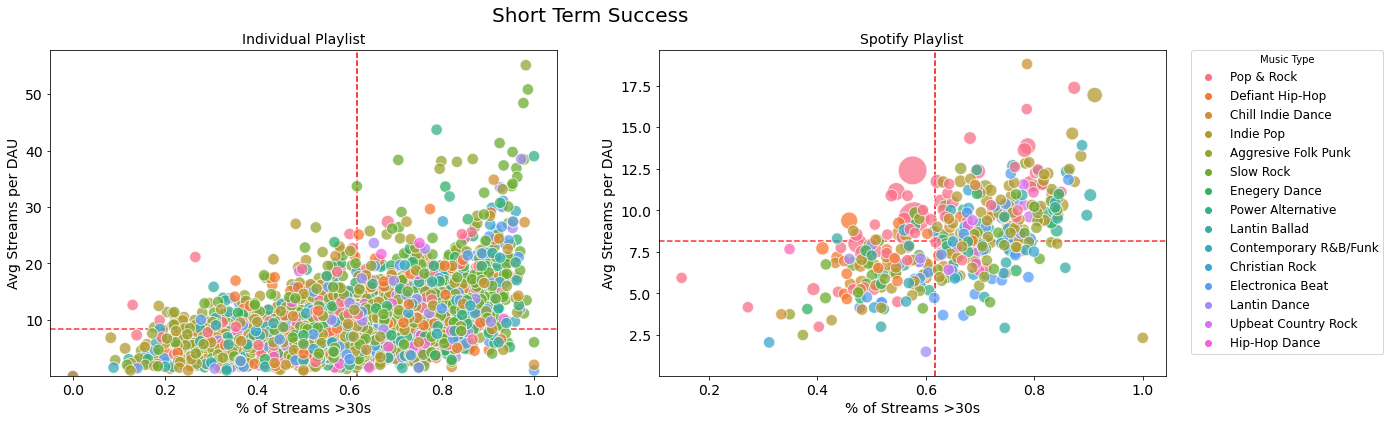

In [48]:
# Short term 
owner_dic = {'Individual':0, 'Spotify':1}
_, f = plt.subplots(1, 2, figsize=(20, 6))
for i in owner_dic.keys():
    fig = f[owner_dic[i]]
    print('The median of stream_per_dau of {} is {}'.format(i, popular_plst[popular_plst['owner_type']==i]['stream_per_dau'].median()))
    g = sns.scatterplot(data=popular_plst[popular_plst['owner_type']==i].sort_values(by='dau', ascending=False), x='pct_stream30s', y='stream_per_dau',
               hue='music_type', size="dau", sizes=(130, 1000), legend = True, ax=fig, alpha=.75)
    g.set_xlabel('% of Streams >30s', fontsize=14)
    g.set_ylabel('Avg Streams per DAU', fontsize=14)
    # sns.set()
    g.set_title(i+' Playlist', fontsize=14)
    g.tick_params(labelsize=14)
    g.get_legend().remove()





    fig.axvline(popular_plst_st_stats.loc['50%','pct_stream30s'],color='red', linestyle='--', label='Success Cutoff', zorder=0) # x = 99% tile
    fig.axhline(popular_plst[popular_plst['owner_type']==i]['stream_per_dau'].median(),color='red',  alpha=.8, linestyle='--', zorder=0) # x = 99% tile
    # fig.set_xlim(0, popular_plst['pct_stream30s'].quantile(.99))
    fig.set_ylim(0.05, )
    h,l = g.get_legend_handles_labels()


plt.legend(h[1:16],l[1:16],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Music Type', fontsize=12)
plt.suptitle('Short Term Success',fontsize=20)
plt.savefig(file_path + 'short_term_success.png', dpi=300, bbox_inches = 'tight')

### 2.2 Conversion - Long Term

**Success Metrics** 

1. streams per MAU 
    If dail % of streams per MAU  >=median, we think this is a successful playlist
    
2. MOM MAU Retention 
    If  MOM MAU Retention > median, we think this is a successful playlist


**Guardrail Metrics**
1. MAU

In [49]:
lt_popular_plst_summary = popular_plst.groupby(['owner_type'], as_index=False)[group_metrics].agg({'stream_per_mau':'median', 
                                                        'month_to_month_retention':'median'})
lt_popular_plst_summary = lt_popular_plst_summary.rename(columns={'month_to_month_retention': 'MOM User Retention', \
                                       'stream_per_mau': 'Avg Streams per MAU'})
lt_popular_plst_summary.to_csv(file_path +'long_term_success_summary.csv')
lt_popular_plst_summary

,owner_type,Avg Streams per MAU,MOM User Retention
0,Individual,15.164,0.140
1,Spotify,12.137,0.129


In [50]:
popular_plst_lt_stats = popular_plst[['stream_per_mau','month_to_month_retention']].describe()
popular_plst_lt_stats

,stream_per_mau,month_to_month_retention
count,4428.000,4428.000
mean,17.047,0.158
std,11.165,0.107
min,1.619,0.000
25%,9.726,0.092
50%,14.643,0.139
75%,21.340,0.198
max,138.312,1.000


In [51]:
for i in ['mau']:
    print('the mean {} per successful playlist in long term is {}'
          .format(i, round(popular_plst[(popular_plst['month_to_month_retention']>=popular_plst_lt_stats.loc['50%','month_to_month_retention']) & 
            (popular_plst['stream_per_dau']>=popular_plst_lt_stats.loc['50%','stream_per_mau'])][i].median(),0)))

the mean mau per successful playlist in long term is 282.0


The median of stream_per_mau of Individual is 15.163884673748104
The median of month_to_month_retention of Individual is 0.1403508771929824
The median of stream_per_mau of Spotify is 12.13693009118541
The median of month_to_month_retention of Spotify is 0.1294706219864509


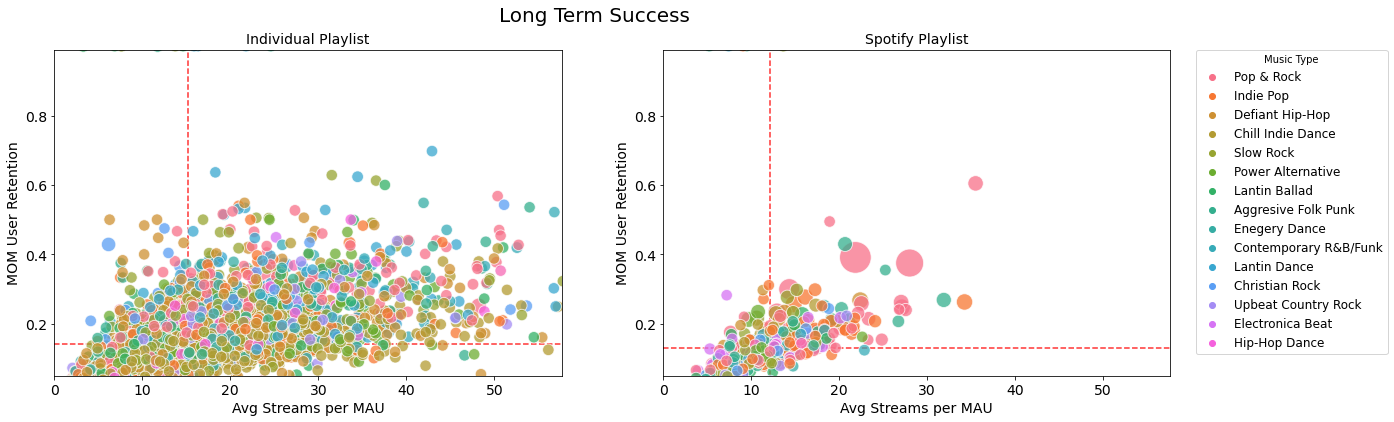

In [274]:
    
# Long term 
owner_dic = {'Individual':0, 'Spotify':1}
_, f = plt.subplots(1, 2, figsize=(20, 6))
for i in owner_dic.keys():
    fig = f[owner_dic[i]]
    print('The median of stream_per_mau of {} is {}'.format(i, popular_plst[popular_plst['owner_type']==i]['stream_per_mau'].median()))
    print('The median of month_to_month_retention of {} is {}'.format(i, popular_plst[popular_plst['owner_type']==i]['month_to_month_retention'].median()))
    g = sns.scatterplot(data=popular_plst[popular_plst['owner_type']==i].sort_values(by='mau', ascending=False), x='stream_per_mau', y='month_to_month_retention',
               hue='music_type', size="mau", sizes=(130, 1000), legend=True, ax=fig, alpha=.75)
    g.set_xlabel('Avg Streams per MAU', fontsize=14)
    g.set_ylabel('MOM User Retention', fontsize=14)
    # sns.set()
    g.set_title(i+' Playlist', fontsize=14)
    g.tick_params(labelsize=14)
    g.get_legend().remove()

    fig.axvline(popular_plst[popular_plst['owner_type']==i]['stream_per_mau'].quantile(.5),color='red', ls='--',  alpha=.8, zorder=0) # x = 99% tile
    fig.axhline(popular_plst[popular_plst['owner_type']==i]['month_to_month_retention'].median(), color='red', ls='--', alpha=.8, zorder=0) # x = 99% tile

    fig.set_xlim(0, popular_plst['stream_per_mau'].quantile(.99))
    fig.set_ylim(0.05, 0.99)

    h,l = g.get_legend_handles_labels()

plt.legend(h[1:16],l[1:16],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Music Type', fontsize=12)
plt.suptitle('Long Term Success',fontsize=20)
plt.savefig(file_path + 'long_term_success.png', dpi=300, bbox_inches = 'tight')

In [53]:
popular_plst['success'] = np.where((popular_plst['stream_per_mau']>=popular_plst_lt_stats.loc['50%','stream_per_mau'])
                                   & (popular_plst['month_to_month_retention']>=popular_plst_lt_stats.loc['50%','month_to_month_retention'])
                                   & (popular_plst['stream_per_dau']>=popular_plst_st_stats.loc['50%','stream_per_dau'])
                                   & (popular_plst['pct_stream30s']>=popular_plst_st_stats.loc['50%','pct_stream30s']), 1, 0)

                                   # & (popular_plst['pct_stream30s']>=0.5), 1, 0)
popular_plst.head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,...,music_type_Lantin Dance,music_type_Slow Rock,music_type_Enegery Dance,music_type_Lantin Ballad,music_type_Hip-Hop Dance,music_type_Mixed Music,music_type_Electronica Beat,music_type_Contemporary R&B/Funk,music_type,success
29,spotify:user:spotify:playlist:2XOX0XoKqciyzmpm...,spotify,223,95,28,88,447,0,0,737,...,0.078,0.147,0.094,-0.098,-0.022,-0.200,-0.018,-0.135,Indie Pop,0
30,spotify:user:spotify:playlist:6A3BCaAJ8O84lo58...,spotify,49158,31127,4711,30856,116427,131460,17878,382105,...,0.064,-0.002,-0.646,-0.371,-0.252,0.201,-0.138,-0.285,Chill Indie Dance,0
54,spotify:user:ee45380827a21adcaba956b31f8f2b92:...,ee45380827a21adcaba956b31f8f2b92,1279,900,66,377,981,645,82,1872,...,0.019,-0.320,-0.015,0.464,-0.409,-0.085,-0.193,-0.428,Christian Rock,0
99,spotify:user:a6842db199a4f04d043aaf79696bdef7:...,a6842db199a4f04d043aaf79696bdef7,107,90,8,42,163,155,18,413,...,0.052,-0.003,-0.014,0.225,-0.025,-0.022,-0.022,0.018,Lantin Ballad,0
107,spotify:user:spotify:playlist:2i0HbrNwqR7TTHFF...,spotify,6448,4979,606,8891,34906,28268,2456,91942,...,0.250,0.224,0.102,-0.043,0.501,0.404,-0.199,-0.071,Indie Pop,0


In [54]:
popular_plst = popular_plst.reset_index()

In [306]:
print(popular_plst.groupby('owner_type')['success'].value_counts())
pe = popular_plst.groupby('owner_type')['success'].value_counts(normalize=True).unstack()
# pe.plot.pie(subplots=True)
pe

owner_type  success
Individual  0          3222
            1           817
Spotify     0           320
            1            69
Name: success, dtype: int64


success,0,1
owner_type,,
Individual,0.798,0.202
Spotify,0.823,0.177


In [56]:
pd.pivot_table(data=popular_plst, index='music_type', columns=['owner_type', 'success'], values='playlist_uri', aggfunc='nunique', margins=True).fillna(0)

owner_type            Individual         Spotify          All
success                        0       1       0      1      
music_type                                                   
Aggresive Folk Punk      109.000  57.000  30.000  7.000   203
Chill Indie Dance        242.000  52.000  29.000  3.000   326
Christian Rock           159.000  67.000  14.000  1.000   241
Contemporary R&B/Funk     74.000  30.000   6.000  2.000   112
Defiant Hip-Hop          527.000  48.000  20.000  1.000   596
Electronica Beat         101.000  37.000  28.000  3.000   169
Enegery Dance             63.000  15.000  11.000  2.000    91
Hip-Hop Dance             14.000   8.000   3.000  0.000    25
Indie Pop                159.000  78.000  52.000 21.000   310
Lantin Ballad            534.000 206.000  16.000  6.000   762
Lantin Dance             154.000  13.000   7.000  0.000   174
Mixed Music               12.000   6.000   2.000  1.000    21
Pop & Rock               620.000 105.000  52.000 15.000   792
Power Alternative        110.000  25.000  17.000  2.000   154
Slow Rock                272.000  50.000  26.000  2.000   350
Upbeat Country Rock       72.000  20.000   7.000  3.000   102
All                     3222.000 817.000 320.000 69.000  4428

In [57]:
music_type_success = pd.pivot_table(data=popular_plst, index='music_type', columns=['success'], values='playlist_uri', aggfunc='nunique', margins=True).fillna(0)
music_type_success = music_type_success.div( music_type_success.iloc[:, -1], axis=0).drop('All', axis=0)*100
# music_type_success
music_type_success_summary = music_type_success[1].sort_values(ascending=False).apply(lambda x: np.round(x, 2)).to_frame('Success Playlist Share')
music_type_success_summary
# np.round(music_type_success_summary, 2)

,Success Playlist Share
music_type,
Mixed Music,33.330
Hip-Hop Dance,32.000
Indie Pop,31.940
Aggresive Folk Punk,31.530
Contemporary R&B/Funk,28.570
Christian Rock,28.220
Lantin Ballad,27.820
Electronica Beat,23.670
Upbeat Country Rock,22.550


In [58]:
# plst_count = df.groupby(['music_type']).agg({'playlist_uri':'nunique'}).apply(lambda x: np.round(x*100/x.sum(), 2))\
#                                 .sort_values('playlist_uri', ascending=False).reset_index()
plst_sample = popular_plst[popular_plst['success']==1].groupby(['music_type'], as_index=False).apply(lambda x: x.sort_values('mau', ascending=False).sample(1))
# plst_summary_by_music_type = plst_count.merge(plst_sample, left_on = 
# plst_sample['Playlist Example'] = plst_sample['playlist_uri'].apply(plst_name)
plst_sample = plst_sample[['playlist_uri', 'music_type']].reset_index()
plst_sample['Playlist Example'] = plst_sample['playlist_uri'].apply(plst_name)
plst_sample

HTTP Error for GET to https://api.spotify.com/v1/playlists/3jvtjbhswlSuYQSVBQVxva with Params: {'fields': None, 'market': None, 'additional_types': 'track'} returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/3xNptuWRxxBb4bb3PEP6rS with Params: {'fields': None, 'market': None, 'additional_types': 'track'} returned 404 due to Not found.


,level_0,level_1,playlist_uri,music_type,Playlist Example
0,0,698,spotify:user:4a0c4499144a277824092256d9940973:...,Aggresive Folk Punk,Country Hits!
1,1,1839,spotify:user:c5aa996554e1679836918a162375f3e2:...,Chill Indie Dance,Study Grind ( EDM Vocals )
2,2,4291,spotify:user:9a3843f792570814673f4351f451c3bc:...,Christian Rock,ULTIMATE CHRISTIAN PLAYLIST!
3,3,4137,spotify:user:7055cde1c445c782732ece62a38ef448:...,Contemporary R&B/Funk,
4,4,2472,spotify:user:c209502720abf1146a30991728d48ca4:...,Defiant Hip-Hop,Christian Rap
5,5,750,spotify:user:2cbece2d22f1f703a2baade24444f7f7:...,Electronica Beat,Cooking Music
6,6,4165,spotify:user:973f1f2dba47f828e9cfdeac4874141f:...,Enegery Dance,Chill n Bass
7,7,2020,spotify:user:223a5553bc7bd0e98fc7bc757ead30d6:...,Hip-Hop Dance,oscar ovidio
8,8,1501,spotify:user:1616a86445e24330dc25c5c1f9703d28:...,Indie Pop,the 1975
9,9,1889,spotify:user:b841daede753a62acab272a16491e248:...,Lantin Ballad,"Camila, Reik, Rio Roma, Sin Banderas , David Z..."


In [59]:
music_type_success_nsp = pd.pivot_table(data=popular_plst[popular_plst['owner_type']!='Spotify'], \
                                       index='music_type', columns=['success'] \
                                       , values='playlist_uri', aggfunc='nunique', margins=True).fillna(0)
music_type_success_nsp = music_type_success_nsp.div( music_type_success_nsp.iloc[:, -1], axis=0).drop('All', axis=0)*100
music_type_success_nsp_summary = music_type_success_nsp[1].sort_values(ascending=True).apply(lambda x: np.round(x, 2)).to_frame('Success Playlist Share')
music_type_success_nsp_summary

,Success Playlist Share
music_type,
Lantin Dance,7.780
Defiant Hip-Hop,8.350
Pop & Rock,14.480
Slow Rock,15.530
Chill Indie Dance,17.690
Power Alternative,18.520
Enegery Dance,19.230
Upbeat Country Rock,21.740
Electronica Beat,26.810


In [60]:
music_type_success_sp = pd.pivot_table(data=popular_plst[popular_plst['owner_type']=='Spotify'], \
                                       index='music_type', columns=['success'] \
                                       , values='playlist_uri', aggfunc='nunique', margins=True).fillna(0)
music_type_success_sp = music_type_success_sp.div( music_type_success_sp.iloc[:, -1], axis=0).drop('All', axis=0)*100
music_type_success_sp_summary = music_type_success_sp[1].sort_values(ascending=False).apply(lambda x: np.round(x, 2)).to_frame('Success Share')
music_type_success_sp_summary.to_csv(file_path + 'success_by_music_type.csv')
music_type_success_sp_summary

,Success Share
music_type,
Mixed Music,33.330
Upbeat Country Rock,30.000
Indie Pop,28.770
Lantin Ballad,27.270
Contemporary R&B/Funk,25.000
Pop & Rock,22.390
Aggresive Folk Punk,18.920
Enegery Dance,15.380
Power Alternative,10.530


In [146]:
popular_plst['dau_rank'] = popular_plst.groupby('owner_type')['dau'].rank(pct = True, method='dense',ascending=True)
popular_plst['%stm>30s_rank'] = popular_plst['pct_stream30s'].rank(pct = True, method='dense',ascending=True)
popular_plst['spd_rank'] = popular_plst['stream_per_dau'].rank(pct = True, method='dense',ascending=True)
popular_plst['spm_rank'] = popular_plst['stream_per_mau'].rank(pct = True, method='dense', ascending=True)
popular_plst['momret_rank'] = popular_plst['month_to_month_retention'].rank(pct = True, method='dense',ascending=True)
popular_plst['mau_rank'] = popular_plst.groupby('owner_type')['mau'].rank(pct = True, method='dense',ascending=True)

popular_plst['sr_conv_rank'] = popular_plst['dau_rank']
popular_plst['sr_eng_rank'] = popular_plst['%stm>30s_rank'] + popular_plst['spd_rank']
popular_plst['sr_eng_rank'] = (popular_plst['sr_eng_rank']-popular_plst['sr_eng_rank'].min())/(popular_plst['sr_eng_rank'].max()-popular_plst['sr_eng_rank'].min())
popular_plst['lr_conv_rank'] = popular_plst['mau_rank']
popular_plst['lr_eng_rank'] = popular_plst['spm_rank']
popular_plst['lr_ret_rank'] = popular_plst['momret_rank']

popular_plst['lr_total_rank'] = popular_plst[['spm_rank', 'momret_rank', 'mau_rank']].sum(axis=1)
popular_plst['total_rank'] = popular_plst[['sr_conv_rank', 'sr_eng_rank', 'lr_conv_rank', 'lr_eng_rank', 'lr_ret_rank']].sum(axis=1)
popular_plst['sr_eng_rank'].describe()

count   4428.000
mean       0.477
std        0.247
min        0.000
25%        0.279
50%        0.467
75%        0.670
max        1.000
Name: sr_eng_rank, dtype: float64

In [199]:
all_win = popular_plst[(popular_plst['sr_conv_rank']>=0.8) &  (popular_plst['sr_eng_rank']>=0.8) \
             & (popular_plst['lr_conv_rank']>=0.8) & (popular_plst['lr_eng_rank']>=0.8) \
             & (popular_plst['lr_ret_rank']>=0.8)].sort_values(by='total_rank', ascending=False).index
st_win = popular_plst[(popular_plst['sr_conv_rank']>=0.7) &  (popular_plst['sr_eng_rank']>=0.7) \
             & (popular_plst['lr_conv_rank']<=0.8) & (popular_plst['lr_eng_rank']<=0.8) \
             & (popular_plst['lr_ret_rank']<=0.8)].sort_values(by='total_rank', ascending=False).index
lr_win = popular_plst[(popular_plst['sr_conv_rank']<=0.6) &  (popular_plst['sr_eng_rank']<=0.6) \
                      & (popular_plst['lr_conv_rank']>=0.8) & (popular_plst['lr_eng_rank']>=0.8) \
             & (popular_plst['lr_ret_rank']>=0.8)].sort_values(by='total_rank', ascending=False).index

In [212]:
all_win

Int64Index([1511, 638, 2457, 3192, 2101], dtype='int64')

In [176]:
f = px.line_polar(
        r = [1,1,1,1,1],
        theta = ['Short Term Conversion','Short Term Engagement', \
                 'Long Term Conversion','Long Term Engagement','Long Term Retention'],
    line_close=True, title="Success Metrics"

    )
f.update_traces(fill='toself', line_width =10, line_color='rgba(255,0,1,0.4)', fillcolor='rgba(255,0,1,0.4)')
f.update_layout(font=dict(
        # family="Courier New, monospace",
        size=25,  # Set the font size here
        # color="RebeccaPurple"
    ))
f.write_image(file_path + "success_polar_sample.png", width=1500, height=1080)

In [236]:
for plst in [3166]:
    polar_df = popular_plst.iloc[plst][['sr_conv_rank', 'sr_eng_rank', 'lr_conv_rank', 'lr_eng_rank', 'lr_ret_rank']].reset_index()\
            .rename(columns={'index':'metric', plst:'percentile'})\
            .replace('sr_conv_rank','Short Term Conversion')\
            .replace('sr_eng_rank','Short Term Engagement')\
            .replace('lr_conv_rank','Long Term Conversion')\
            .replace('lr_eng_rank','Long Term Retention')\
            .replace('lr_ret_rank','Long Term Engagement')
    # title = popular_plst['tokens'].iloc[plst]
    # spotify.playlist(popular_plst.iloc[plst]['playlist_uri'])['name']

    fig = px.line_polar(polar_df, r='percentile', theta='metric', line_close=True,  range_r=[0,1], \
                        line_shape = 'linear', template="seaborn")
    # title=title,
    fig.update_traces(fill='toself', line_color='rgba(255,0,1,0.4)', fillcolor='rgba(255,0,1,0.4)')
    fig.update_layout(font=dict(
        # family="Courier New, monospace",
        size=45,  # Set the font size here
        # color="RebeccaPurple"
    ))
    fig.write_image(file_path + "success_polar_sample_{}.png".format(plst), width=1500, height=1080)
    fig.show()

In [225]:
print(popular_plst.iloc[3166]['music_type'])
print(popular_plst.iloc[3166]['tokens'])

Pop & Rock
["epic", "songs"]


In [238]:
# sample = popular_plst.iloc[3166]['playlist_uri']
# spotify.playlist(sample)['images'][0]['url']

In [ ]:
def plst_image(x):
     img=spotify.playlist(playlist_uri)['images']
    if len(img)>2:
        image = results['images'][math.floor(len(results['images'])/2)]['url']
    else: 
        img = results['images'][0]['url']

## Success Prediction

### Freature Engineering

In [239]:
popular_plst['tracks_per_artist'] = popular_plst['n_tracks']/popular_plst['n_artists']
popular_plst['tracks_per_album'] = popular_plst['n_tracks']/popular_plst['n_albums']
popular_plst['tracks_change_share'] = popular_plst['n_local_tracks']/popular_plst['n_tracks']
popular_plst['num_of_token'] = popular_plst['tokens'].str.split(',').str.len()

In [240]:
filepath = '/Users/danielma/Documents/Spotify/Data/popular_plst.csv'
popular_plst.to_csv(filepath, index=False)

In [241]:
popular_plst= pd.read_csv(filepath).drop('index', axis=1)
popular_plst.head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,...,total_rank,sr_conv_rank,sr_eng_rank,lr_conv_rank,lr_eng_rank,lr_ret_rank,tracks_per_artist,tracks_per_album,tracks_change_share,num_of_token
0,spotify:user:spotify:playlist:2XOX0XoKqciyzmpm...,spotify,223,95,28,88,447,0,0,737,...,0.349,0.052,0.120,0.039,0.137,0.000,1.000,1.000,0.000,2
1,spotify:user:spotify:playlist:6A3BCaAJ8O84lo58...,spotify,49158,31127,4711,30856,116427,131460,17878,382105,...,2.732,0.805,0.399,0.876,0.203,0.449,26.000,26.000,0.000,4
2,spotify:user:ee45380827a21adcaba956b31f8f2b92:...,ee45380827a21adcaba956b31f8f2b92,1279,900,66,377,981,645,82,1872,...,2.714,0.212,0.740,0.588,0.769,0.405,1.562,1.316,0.000,3
3,spotify:user:a6842db199a4f04d043aaf79696bdef7:...,a6842db199a4f04d043aaf79696bdef7,107,90,8,42,163,155,18,413,...,1.657,0.028,0.790,0.032,0.455,0.351,30.250,11.000,0.000,4
4,spotify:user:spotify:playlist:2i0HbrNwqR7TTHFF...,spotify,6448,4979,606,8891,34906,28268,2456,91942,...,2.195,0.449,0.610,0.691,0.242,0.203,1.064,1.020,0.000,2


## Logistic Regression

In [242]:
X_cols = ['n_tracks', 'n_local_tracks', 'n_artists', 'n_albums', 'num_of_token'] \
           + [x for x in popular_plst.columns if 'music_type' in x and x !='music_type'] \
            # + ['tracks_per_artist', 'tracks_per_album', 'tracks_change_share','num_of_token'] 
y_cols = ['success']

X = popular_plst[X_cols]
y = popular_plst[y_cols]

In [243]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
def cv(model, score):
    cv = cross_val_score(model, X, y, cv=skf, scoring=score)
    return cv
lr = LogisticRegression(random_state=24)

In [244]:
model = lr
score = ['accuracy', 'precision', 'recall', 'f1_micro', 'f1_macro']
for s in score:
    print('The CV {} of {} classifier is {}'.format(s, 'Logistic Regression', round(cv(model=model, score=s).mean(), 2)))

The CV accuracy of Logistic Regression classifier is 0.8
The CV precision of Logistic Regression classifier is 0.54
The CV recall of Logistic Regression classifier is 0.02
The CV f1_micro of Logistic Regression classifier is 0.8
The CV f1_macro of Logistic Regression classifier is 0.46


In [245]:
for train_idx, test_idx in skf.split(X,y):
    print("TRAIN:", train_idx.shape, "TEST:", test_idx.shape)
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    
    mod = lr.fit(X_train, y_train)
    
    print(confusion_matrix(y_train,lr.predict(X_train)))
    print(classification_report(y_test,lr.predict(X_test)))

TRAIN: (3542,) TEST: (886,)
[[2820   13]
 [ 697   12]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       709
           1       0.75      0.02      0.03       177

    accuracy                           0.80       886
   macro avg       0.78      0.51      0.46       886
weighted avg       0.79      0.80      0.72       886

TRAIN: (3542,) TEST: (886,)
[[2821   12]
 [ 693   16]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       709
           1       0.30      0.02      0.03       177

    accuracy                           0.80       886
   macro avg       0.55      0.50      0.46       886
weighted avg       0.70      0.80      0.72       886

TRAIN: (3542,) TEST: (886,)
[[2813   21]
 [ 689   19]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       708
           1       0.57      0.02      0.04       178

    accuracy     

## Random Forest

In [247]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10,  \
                            min_samples_leaf=4, random_state=24)
model = rf
# score = ['accuracy', 'precision', 'recall', 
for s in score:
    print('The CV {} of {} classifier is {}'.format(s, 'Random Forest', round(cv(model=model, score=s).mean(), 2)))

The CV accuracy of Random Forest classifier is 0.81
The CV precision of Random Forest classifier is 0.6
The CV recall of Random Forest classifier is 0.09
The CV f1_micro of Random Forest classifier is 0.81
The CV f1_macro of Random Forest classifier is 0.53


In [248]:
for train_idx, test_idx in skf.split(X,y):
    print("TRAIN:", train_idx.shape, "TEST:", test_idx.shape)
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    
    mod = rf.fit(X_train, y_train)
    
    print(confusion_matrix(y_train,rf.predict(X_train)))
    print(classification_report(y_test,rf.predict(X_test)))

TRAIN: (3542,) TEST: (886,)
[[2809   24]
 [ 579  130]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       709
           1       0.59      0.09      0.16       177

    accuracy                           0.81       886
   macro avg       0.70      0.54      0.52       886
weighted avg       0.77      0.81      0.74       886

TRAIN: (3542,) TEST: (886,)
[[2820   13]
 [ 570  139]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       709
           1       0.50      0.08      0.14       177

    accuracy                           0.80       886
   macro avg       0.66      0.53      0.51       886
weighted avg       0.75      0.80      0.74       886

TRAIN: (3542,) TEST: (886,)
[[2813   21]
 [ 562  146]]
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       708
           1       0.66      0.11      0.18       178

    accuracy     

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [250]:
# RF
rf = RandomForestClassifier(n_estimators=75, max_depth=10,  \
                            min_samples_leaf=2, random_state=24)
rf.fit(X_train, y_train)
y_pre_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# LR
lr = lr = LogisticRegression(random_state=24)

lr.fit(X_train, y_train)
y_pre_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

In [251]:
# roc_auc_score(y_test, y_prob_lr, average='micro')

In [252]:
# roc_auc_score(y_test, y_prob_lr, average='weighted')

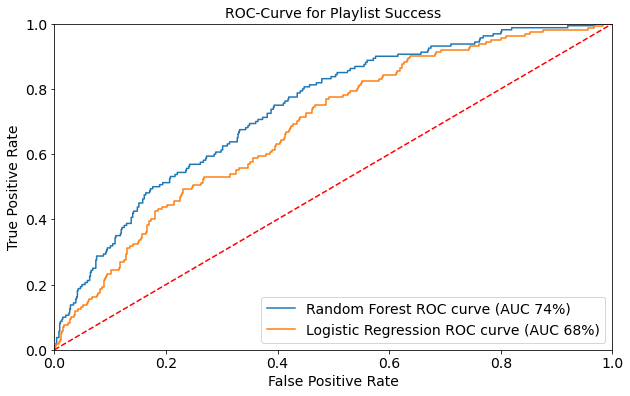

In [289]:
fpr_rf, tpr_rf, thre_rf = roc_curve(y_test, y_prob_rf)
fpr_lr, tpr_lr, thre_lr = roc_curve(y_test, y_prob_lr)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest ROC curve (AUC {:.0f}%)'.format(roc_auc_score(y_test, y_prob_rf, average='micro')*100))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression ROC curve (AUC {:.0f}%)'.format(roc_auc_score(y_test, y_prob_lr, average='micro')*100))
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('ROC-Curve for Playlist Success', fontsize=14)

# metrics.plot_roc_curve(estimator=rf, X=X_test, y=y_test)
plt.plot([0, 1], [0,1], c='r', linestyle='--', lw=1.5)
plt.legend(fontsize=14)
plt.savefig(file_path + 'model_performance.png', facecolor='white', transparent=False, dpi=300)

In [270]:
rf.fit(X,y)

importances = rf.feature_importances_
idx = np.argsort(importances)[::-1]
imp = importances[idx]
num = len(idx)
cols_ordered = []
for i in range(num):
    cols_ordered.append(X.columns[idx[i]])
    print('{:d}. {:s} {:.3f}'.format(i+1, X.columns[idx[i]], imp[i]))

1. n_tracks 0.165
2. n_albums 0.111
3. n_artists 0.099
4. num_of_token 0.048
5. music_type_Defiant Hip-Hop 0.045
6. music_type_Christian Rock 0.045
7. music_type_Mixed Music 0.042
8. music_type_Indie Pop 0.040
9. music_type_Lantin Ballad 0.040
10. music_type_Enegery Dance 0.037
11. music_type_Aggresive Folk Punk 0.036
12. music_type_Hip-Hop Dance 0.034
13. music_type_Lantin Dance 0.034
14. music_type_Electronica Beat 0.032
15. music_type_Chill Indie Dance 0.030
16. music_type_Slow Rock 0.030
17. music_type_Contemporary R&B/Funk 0.028
18. music_type_Upbeat Country Rock 0.027
19. n_local_tracks 0.027
20. music_type_Power Alternative 0.025
21. music_type_Pop & Rock 0.025


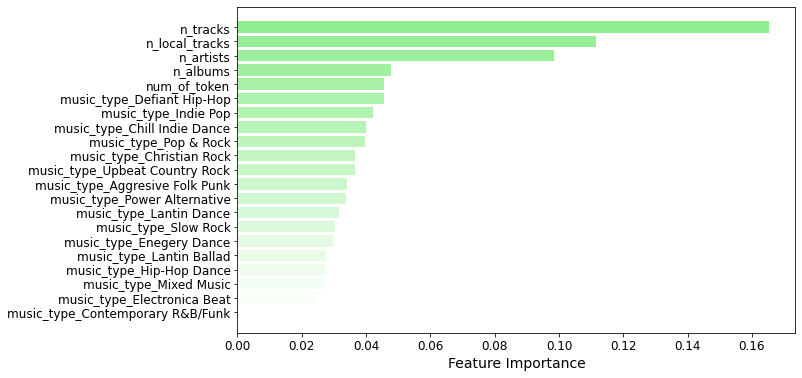

In [294]:
plt.figure(figsize=(10, 6))
# plt.barh(X.columns[::-1], imp[::-1], color=[str((i/float(num+i))) for i in range(num)]);
plt.barh(X.columns[::-1], imp[::-1], color=[to_rgba('lightgreen', alpha=i / 20) for i in range(21)])

plt.xlabel('Feature Importance', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
# plt.legend(bar, [X.columns[idx[i]] for i in range(num)])
# plt.legend(title='Features', loc='center left', bbox_to_anchor=(1, 0.7));
plt.savefig(file_path + 'feature_importance.png', facecolor='white', transparent=False, dpi=300,bbox_inches = 'tight')